In [97]:
import os
import logging
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, f1_score, recall_score, 
    roc_curve, auc, ConfusionMatrixDisplay, mean_squared_error, r2_score
)

from lightgbm import LGBMRegressor


from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from ydata_profiling import ProfileReport

import seaborn as sns

import shap
from catboost import CatBoostClassifier
from scipy.stats import boxcox

plt.style.use('ggplot')
%matplotlib inline

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [ ]:
class BikeDemandDataProcessor:
    def __init__(self, path):
        self.path = path

    def load_data(self, filename):
        full_path = f"{self.path}/{filename}"
        print(f"Loading data from {full_path}")
        try:
            return pd.read_csv(full_path)
        except FileNotFoundError:
            print(f"File {filename} not found in path {self.path}.")
            return None

    def preprocess(self, df):

        df = df.copy()

        # Creating timestamp column
        df['timestamp'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')

        # Renaming columns
        df = df.rename(columns={'hr': 'hour', 'yr' : 'year', 'mnth' : 'month', 'cnt' : 'count'})
        df = df.drop(['dteday', 'instant'], axis=1)
        
        # Time features
        df['year'] = df['timestamp'].dt.year
        df['day'] = df['timestamp'].dt.day_of_year
        df['day_of_week'] = df['timestamp'].dt.day_of_week
        df['day_of_month'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['week'] = df['timestamp'].dt.isocalendar().week
        
        # Cyclic encoding
        df['year_sin'] = np.sin(2 * np.pi * df['year'])
        df['year_cos'] = np.cos(2 * np.pi * df['year'])
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
        
        # Day type features
        df['working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
        df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        df['is_monday'] = (df['day_of_week'] == 0).astype(int)
        df['is_friday'] = (df['day_of_week'] == 4).astype(int)
        
        # Special periods
        df['moonphase'] = df['timestamp'].apply(lambda x: (x.day + x.month * 29.53) % 29.53)
        df['quarter'] = df['timestamp'].dt.quarter
        df['christmas_holiday_season'] = df['timestamp'].apply(lambda x: 1 if (x.month == 1 and x.day <= 14) or (x.month == 12 and x.day >= 24) else 0)
        df['summer_season'] = df['timestamp'].apply(lambda x: 1 if 6 <= x.month <= 8 else 0)
        df['spring_season'] = df['timestamp'].apply(lambda x: 1 if 3 <= x.month <= 5 else 0)
        df['fall_season'] = df['timestamp'].apply(lambda x: 1 if 9 <= x.month <= 11 else 0)
        df['winter_season'] = df['timestamp'].apply(lambda x: 1 if x.month in [12, 1, 2] else 0)
        df['day_of_year'] = df['timestamp'].dt.dayofyear
        
        # Hour features (rush hour made estimated form visualisations)
        df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18) & (df['working_day'] == 1)).astype(int)
        df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
        df['rush_hour'] = df.apply(lambda x: 1 if ((x['hour'] >= 4 and x['hour'] <= 10) or (x['hour'] >= 15 and x['hour'] <= 21)) and x['working_day'] == 1 else 0, axis=1)

        # Creating interaction features
        df['hum_windspeed'] = df['hum'] * df['windspeed']
        df['temp_hum'] = df['temp'] * df['hum']
        df['temp_windspeed'] = df['temp'] * df['windspeed']
        df['windspeed_squared'] = df['windspeed'] ** 2
        df['hum_squared'] = df['hum'] ** 2
        
        # Weather interaction features
        df['weather_temp'] = df['weathersit'] * df['temp']
        df['weather_hum'] = df['weathersit'] * df['hum']
        df['weather_windspeed'] = df['weathersit'] * df['windspeed']
        
        # Atemp interaction features
        df['atemp_hum'] = df['atemp'] * df['hum']
        df['atemp_windspeed'] = df['atemp'] * df['windspeed']
        df['atemp_squared'] = df['atemp'] ** 2
        df['temp_atemp'] = df['temp'] * df['atemp']
        df['weather_atemp'] = df['weathersit'] * df['atemp']
        
        # Temperature difference feature
        df['temp_atemp_diff'] = np.abs(df['temp'] - df['atemp'])

        # Convert object columns to category
        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype('category')

        return df.drop_duplicates()
    
    def feature_engineering(self, train_df, val_df):
        train_df = train_df.copy()
        val_df = val_df.copy()

        # Avoid division by zero
        casual_sum = train_df['casual'].sum()
        if casual_sum == 0:
            casual_sum = 1  # Prevent division by zero

        total_ratio_of_registered_uses = train_df['registered'].sum() / casual_sum

        # Average ratios for different time-based groupings
        average_hour_ratio = train_df.groupby('hour').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_day_ratio = train_df.groupby('day_of_week').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_week_ratio = train_df.groupby('week').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_month_ratio = train_df.groupby('month').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_season_ratio = train_df.groupby('season').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_weekend_ratio = train_df.groupby('weekend').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_working_day_ratio = train_df.groupby('working_day').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']



        # Applying ratios to both train and validation sets
        train_df['total_registered_ratio'] = total_ratio_of_registered_uses
        val_df['total_registered_ratio'] = total_ratio_of_registered_uses

        train_df['hour_ratio'] = train_df['hour'].map(average_hour_ratio)
        val_df['hour_ratio'] = val_df['hour'].map(average_hour_ratio)

        train_df['day_ratio'] = train_df['day_of_week'].map(average_day_ratio)
        val_df['day_ratio'] = val_df['day_of_week'].map(average_day_ratio)

        # Mapping working day and weekend registered ratios (could go further and do this for each motnh, week, etc.)
        train_df['working_day_or_weekend_ratio'] = train_df['working_day'].map(average_working_day_ratio).where(train_df['working_day'] == 1, 
                                                                                                                        train_df['weekend'].map(average_weekend_ratio))
        val_df['working_day_or_weekend_ratio'] = val_df['working_day'].map(average_working_day_ratio).where(val_df['working_day'] == 1, 
                                                                                                                    val_df['weekend'].map(average_weekend_ratio))

        train_df['week_ratio'] = train_df['week'].map(average_week_ratio)
        val_df['week_ratio'] = val_df['week'].map(average_week_ratio)

        train_df['month_ratio'] = train_df['month'].map(average_month_ratio)
        val_df['month_ratio'] = val_df['month'].map(average_month_ratio)

        train_df['season_ratio'] = train_df['season'].map(average_season_ratio)
        val_df['season_ratio'] = val_df['season'].map(average_season_ratio)

        # Dropping columns that won't be available for prediction
        train_df = train_df.drop(['casual', 'registered'], axis=1)
        val_df = val_df.drop(['casual', 'registered'], axis=1)

        ## An idea to try and project outliers into the future as I saw some seemed to be repeated so maybe a notable event of som sort
        # Aggregate counts to daily level
        daily_train_df = train_df.groupby(['year', 'month', 'day', 'day_of_year'])[['count']].sum().reset_index()

        # Calculate rolling mean and standard deviation (2-week window)
        rolling_mean = daily_train_df['count'].rolling(window=14, center=True).mean()
        rolling_std = daily_train_df['count'].rolling(window=14, center=True).std()

        # Identify 3-sigma outliers
        daily_train_df['sigma_3_outlier'] = (daily_train_df['count'] > rolling_mean + 3 * rolling_std) | \
                                            (daily_train_df['count'] < rolling_mean - 3 * rolling_std)

        # Find max outlier flag per day_of_year
        day_of_year_outlier = daily_train_df.groupby('day_of_year', as_index=False)['sigma_3_outlier'].max()

        # Merge back into train_df and val_df
        train_df = train_df.merge(day_of_year_outlier, on='day_of_year', how='left')
        val_df = val_df.merge(day_of_year_outlier, on='day_of_year', how='left')

        # Fill NaN values (if no outlier was detected for that day, assume False)
        train_df['sigma_3_outlier'] = train_df['sigma_3_outlier'].fillna(0)
        val_df['sigma_3_outlier'] = val_df['sigma_3_outlier'].fillna(0)

        return train_df.drop_duplicates(), val_df.drop_duplicates()
            
    def split_and_engineer_data(self, df):
        sorted_df = df.sort_values('timestamp').copy()
        sorted_df = sorted_df.drop('timestamp', axis=1)

        original_shape = sorted_df.drop(['casual', 'registered'], axis = 1).shape  # Store original shape

        train_df, val_df = train_test_split(sorted_df, test_size=0.2, shuffle=False)

        train_df, val_df = self.feature_engineering(train_df, val_df)

        # Ensure row count is unchanged when reducing back to original columns
        original_columns = sorted_df.drop(['casual', 'registered'], axis = 1).columns.tolist()
        
        reduced_train = train_df[original_columns]
        reduced_val = val_df[original_columns]

        combined_df = pd.concat([reduced_train, reduced_val])

        assert combined_df.shape == original_shape, "Row count mismatch after feature engineering!"

        return train_df, val_df


# Data Loading

## Dataset Characteristics

Both `hour.csv` and `day.csv` have the following fields, except `hr` which is not available in `day.csv`:

- **instant**: record index
- **dteday**: date
- **season**: season (1: spring, 2: summer, 3: fall, 4: winter)
- **yr**: year (0: 2011, 1: 2012)
- **mnth**: month (1 to 12)
- **hr**: hour (0 to 23)
- **holiday**: whether the day is a holiday or not
- **day_of_week**: day of the week
- **workingday**: if the day is neither weekend nor holiday is 1, otherwise is 0
- **weathersit**:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp**: Normalized temperature in Celsius. The values are divided by 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided by 50 (max)
- **hum**: Normalized humidity. The values are divided by 100 (max)
- **windspeed**: Normalized wind speed. The values are divided by 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

In [99]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)
hour_raw_df = processor.load_data("data/hour.csv")
hour_processed_df = processor.preprocess(hour_raw_df)

Loading data from C:\Users\Lawrence\Documents\PYTHON\bike_demand_2025/data/hour.csv


In [100]:
test_df = hour_processed_df[-14:]
test_df.to_csv("data/processed_data/test.csv", index=False)
train_df, val_df = processor.split_and_engineer_data(hour_processed_df[:-14])

**Orginal Data**

In [101]:
hour_raw_df.head(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  01/01/2011       1   0     1   0        0        6           0   
1        2  01/01/2011       1   0     1   1        0        6           0   
2        3  01/01/2011       1   0     1   2        0        6           0   
3        4  01/01/2011       1   0     1   3        0        6           0   
4        5  01/01/2011       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

**Data with Time Features and Other Feature Engineering**

In [102]:
hour_processed_df.head(5)

season  year  month  hour  holiday  weekday  workingday  weathersit  temp  \
0       1  2011      1     0        0        6           0           1  0.24   
1       1  2011      1     1        0        6           0           1  0.22   
2       1  2011      1     2        0        6           0           1  0.22   
3       1  2011      1     3        0        6           0           1  0.24   
4       1  2011      1     4        0        6           0           1  0.24   

    atemp  ...  hum_squared  weather_temp  weather_hum  weather_windspeed  \
0  0.2879  ...       0.6561          0.24         0.81                0.0   
1  0.2727  ...       0.6400          0.22         0.80                0.0   
2  0.2727  ...       0.6400          0.22         0.80                0.0   
3  0.2879  ...       0.5625          0.24         0.75                0.0   
4  0.2879  ...       0.5625          0.24         0.75                0.0   

   atemp_hum atemp_windspeed  atemp_squared  temp_atemp  weather_atemp  \
0   0.233199             0.0       0.082886    0.069096         0.2879   
1   0.218160             0.0       0.074365    0.059994         0.2727   
2   0.218160             0.0       0.074365    0.059994         0.2727   
3   0.215925             0.0       0.082886    0.069096         0.2879   
4   0.215925             0.0       0.082886    0.069096         0.2879   

   temp_atemp_diff  
0           0.0479  
1           0.0527  
2           0.0527  
3           0.0479  
4           0.0479  

[5 rows x 59 columns]

In [103]:
hour_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   season                    17379 non-null  int64         
 1   year                      17379 non-null  int32         
 2   month                     17379 non-null  int32         
 3   hour                      17379 non-null  int64         
 4   holiday                   17379 non-null  int64         
 5   weekday                   17379 non-null  int64         
 6   workingday                17379 non-null  int64         
 7   weathersit                17379 non-null  int64         
 8   temp                      17379 non-null  float64       
 9   atemp                     17379 non-null  float64       
 10  hum                       17379 non-null  float64       
 11  windspeed                 17379 non-null  float64       
 12  casual            

In [104]:
hour_processed_df.head()

season  year  month  hour  holiday  weekday  workingday  weathersit  temp  \
0       1  2011      1     0        0        6           0           1  0.24   
1       1  2011      1     1        0        6           0           1  0.22   
2       1  2011      1     2        0        6           0           1  0.22   
3       1  2011      1     3        0        6           0           1  0.24   
4       1  2011      1     4        0        6           0           1  0.24   

    atemp  ...  hum_squared  weather_temp  weather_hum  weather_windspeed  \
0  0.2879  ...       0.6561          0.24         0.81                0.0   
1  0.2727  ...       0.6400          0.22         0.80                0.0   
2  0.2727  ...       0.6400          0.22         0.80                0.0   
3  0.2879  ...       0.5625          0.24         0.75                0.0   
4  0.2879  ...       0.5625          0.24         0.75                0.0   

   atemp_hum atemp_windspeed  atemp_squared  temp_atemp  weather_atemp  \
0   0.233199             0.0       0.082886    0.069096         0.2879   
1   0.218160             0.0       0.074365    0.059994         0.2727   
2   0.218160             0.0       0.074365    0.059994         0.2727   
3   0.215925             0.0       0.082886    0.069096         0.2879   
4   0.215925             0.0       0.082886    0.069096         0.2879   

   temp_atemp_diff  
0           0.0479  
1           0.0527  
2           0.0527  
3           0.0479  
4           0.0479  

[5 rows x 59 columns]

**No Nulls in Data**

In [105]:
null_counts = hour_processed_df.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


**Some checks to see the alignment of days**

In [106]:
hour_processed_df[['day', 'day_of_week', 'workingday', 'weekend']].drop_duplicates().head(7)

day  day_of_week  workingday  weekend
0      1            5           0        1
24     2            6           0        1
47     3            0           1        0
69     4            1           1        0
92     5            2           1        0
115    6            3           1        0
138    7            4           1        0

In [107]:
hour_raw_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

**Correlation Heat Map of Raw Data**

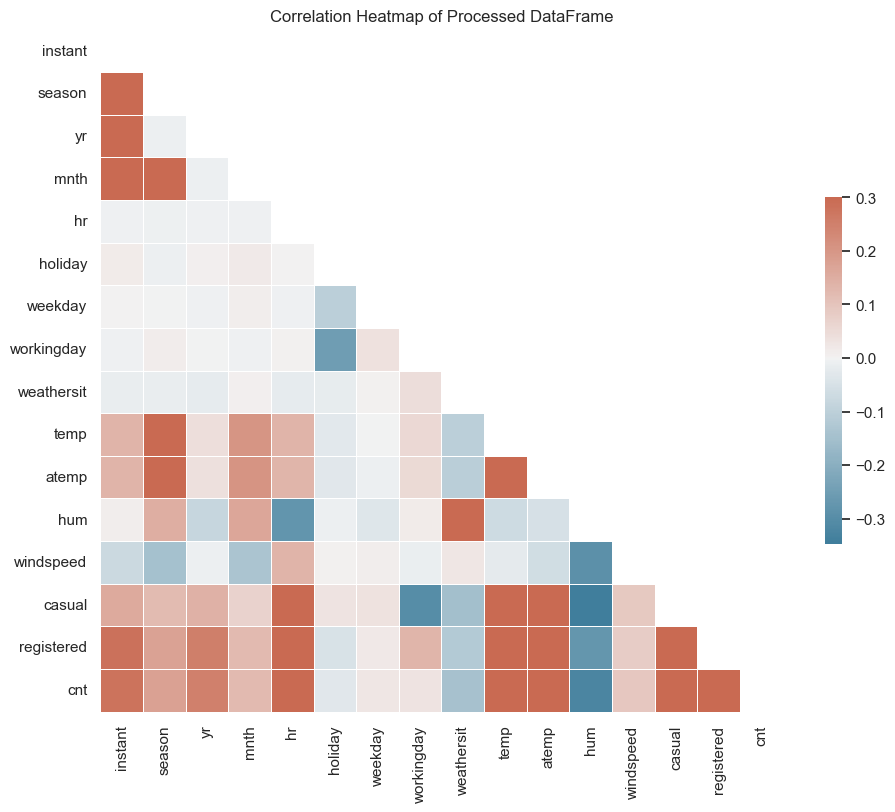

In [108]:
hour_raw_df_numeric = hour_raw_df.drop(['dteday'], axis = 1).apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

sns.set_theme(style="white")

corr = hour_raw_df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Processed DataFrame')
plt.show()

**Correlation Heat Map of Processed Data**

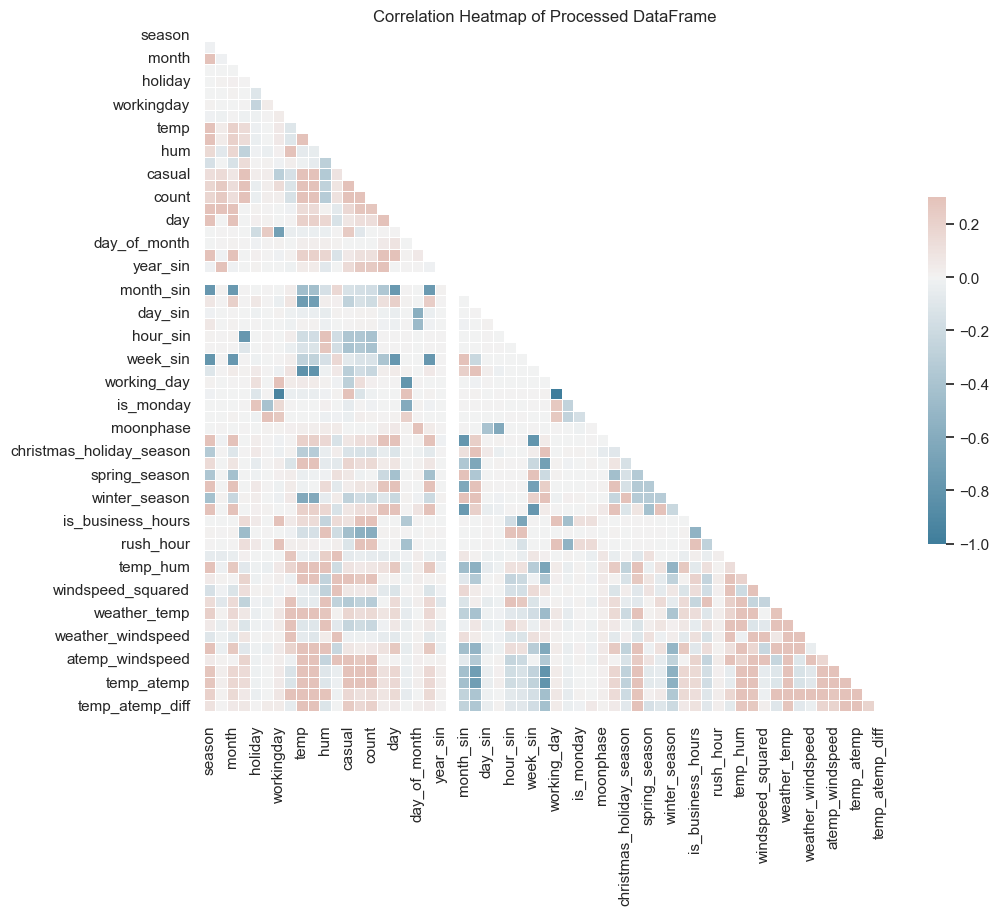

In [109]:
hour_processed_df_numeric = hour_processed_df.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

sns.set_theme(style="white")

corr = hour_processed_df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Processed DataFrame')
plt.show()

**Correlation Heat Map of Split and Extra Processed Data**

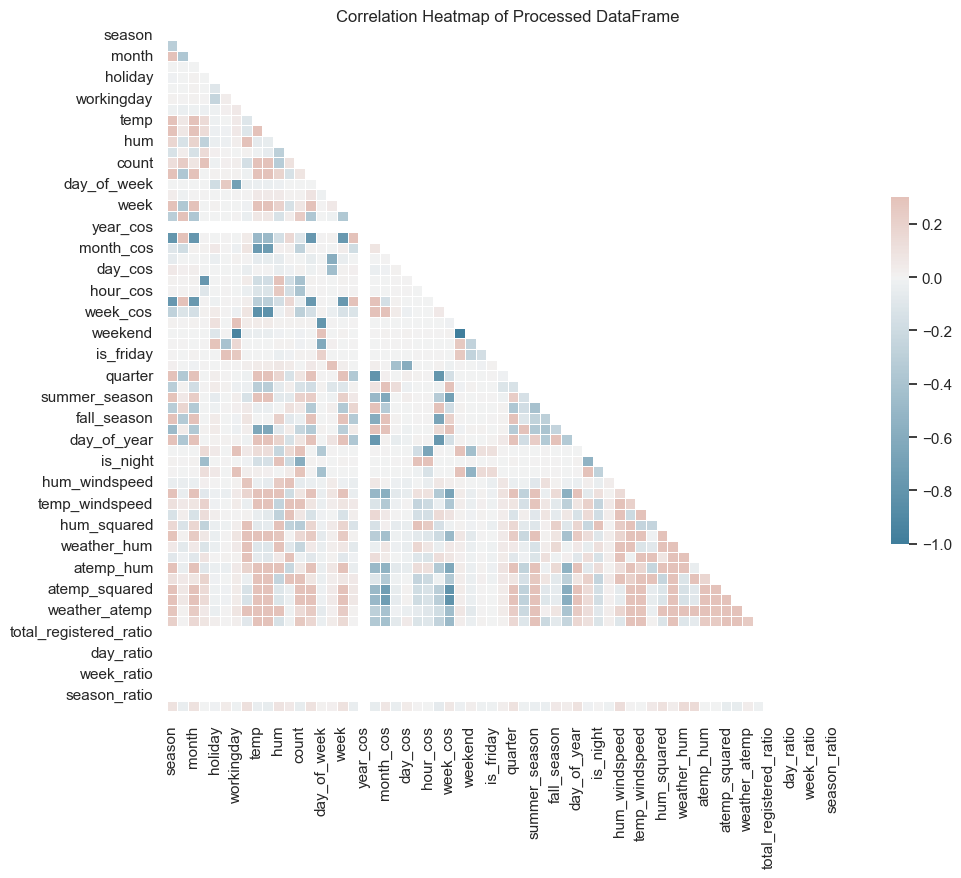

In [110]:
train_df_numeric = train_df.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

sns.set_theme(style="white")

corr = train_df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Processed DataFrame')
plt.show()

## Feature Visualisations

### Year on Year Timeseries by Day Showing Notable Points
- Holidays marked dont seem to create much change, maybe the holiday data is wrong
- Some outliers detected fall around the same place each year, this could potentially be used in future years as a flag feature

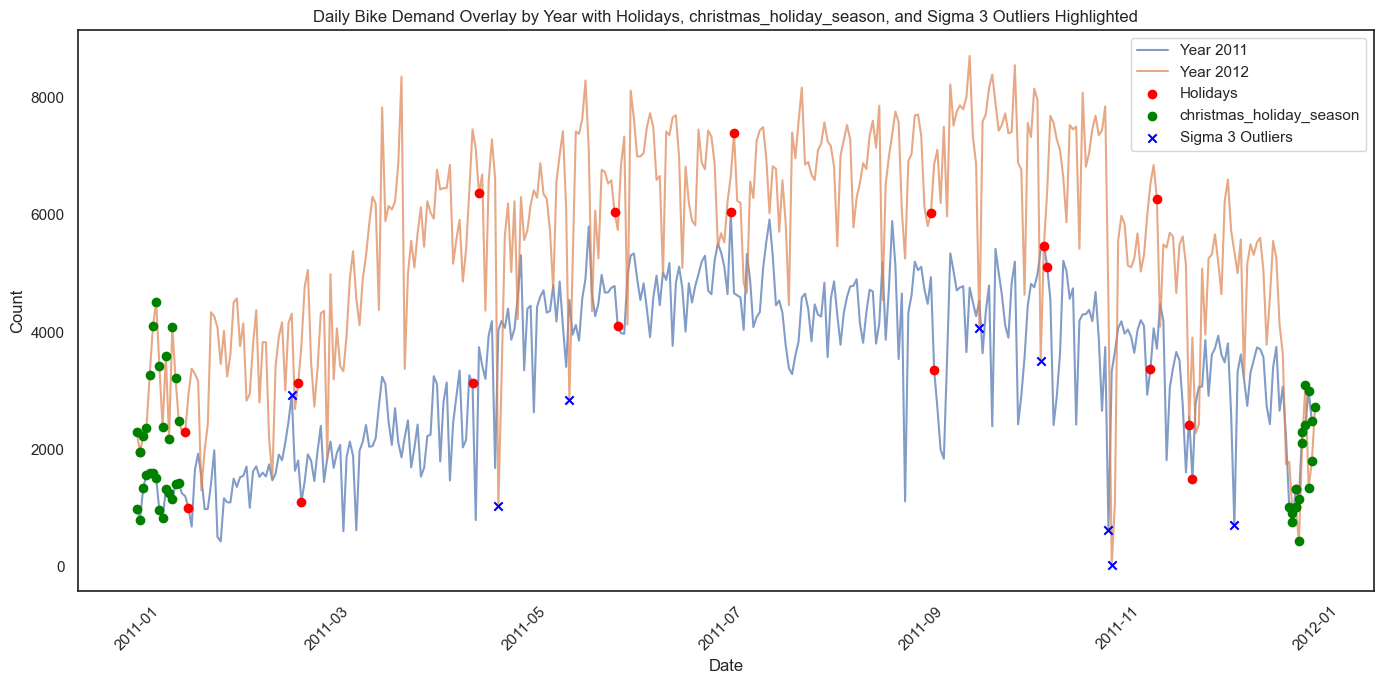

In [111]:
daily_counts = hour_processed_df.resample('D', on='timestamp').agg({
    'holiday': 'max',
    'christmas_holiday_season': 'max',
    'count': 'sum',
})
daily_counts.index = pd.to_datetime(daily_counts.index)

daily_counts['year'] = daily_counts.index.year

daily_counts['day_of_year'] = daily_counts.index.dayofyear
daily_counts['normalized_date'] = pd.to_datetime('2011-01-01') + pd.to_timedelta(daily_counts['day_of_year'] - 1, unit='D')

daily_counts = daily_counts.sort_values(['year', 'normalized_date'])

rolling_mean = daily_counts['count'].rolling(window=30, center=True).mean()
rolling_std = daily_counts['count'].rolling(window=30, center=True).std()

daily_counts['sigma_3_outlier'] = (daily_counts['count'] > rolling_mean + 3 * rolling_std) | (daily_counts['count'] < rolling_mean - 3 * rolling_std)

plt.figure(figsize=(14, 7))

for year in daily_counts['year'].unique():
    yearly_data = daily_counts[daily_counts['year'] == year]
    plt.plot(yearly_data['normalized_date'], yearly_data['count'], label=f'Year {year}', alpha=0.7)

holidays = daily_counts[daily_counts['holiday'] == 1]
plt.scatter(holidays['normalized_date'], holidays['count'], color='red', label='Holidays', zorder=5)

christmas_holiday_season = daily_counts[daily_counts['christmas_holiday_season'] == 1]
plt.scatter(christmas_holiday_season['normalized_date'], christmas_holiday_season['count'], color='green', label='christmas_holiday_season', marker='o', zorder=6)

sigma_3_outliers = daily_counts[daily_counts['sigma_3_outlier'] == True]
plt.scatter(sigma_3_outliers['normalized_date'], sigma_3_outliers['count'], color='blue', label='Sigma 3 Outliers', marker='x', zorder=7)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Bike Demand Overlay by Year with Holidays, christmas_holiday_season, and Sigma 3 Outliers Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


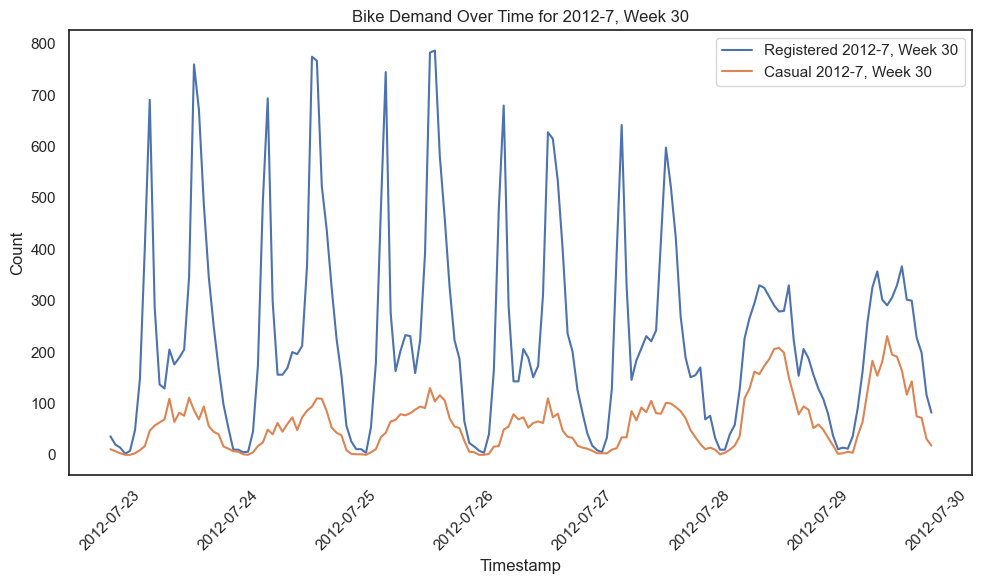

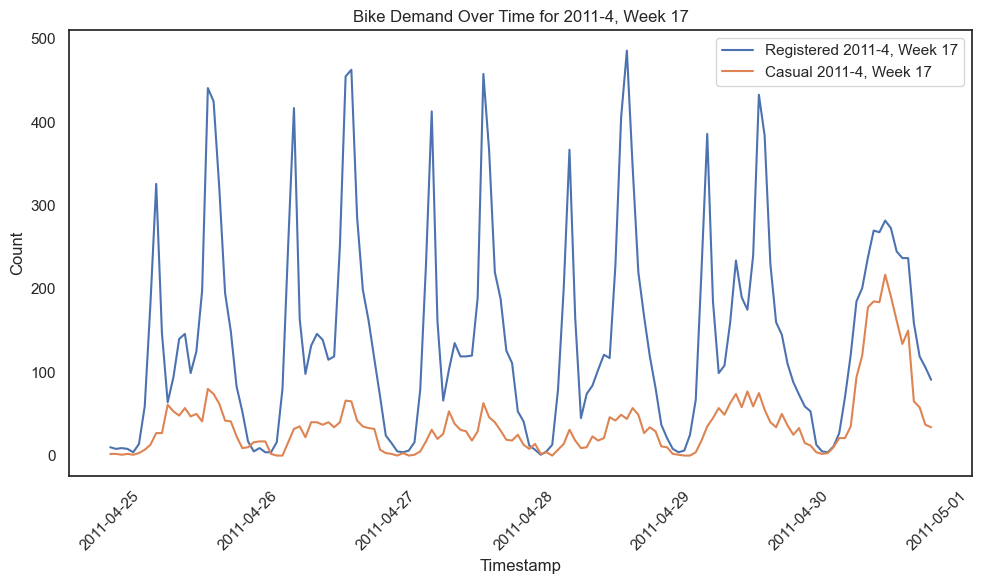

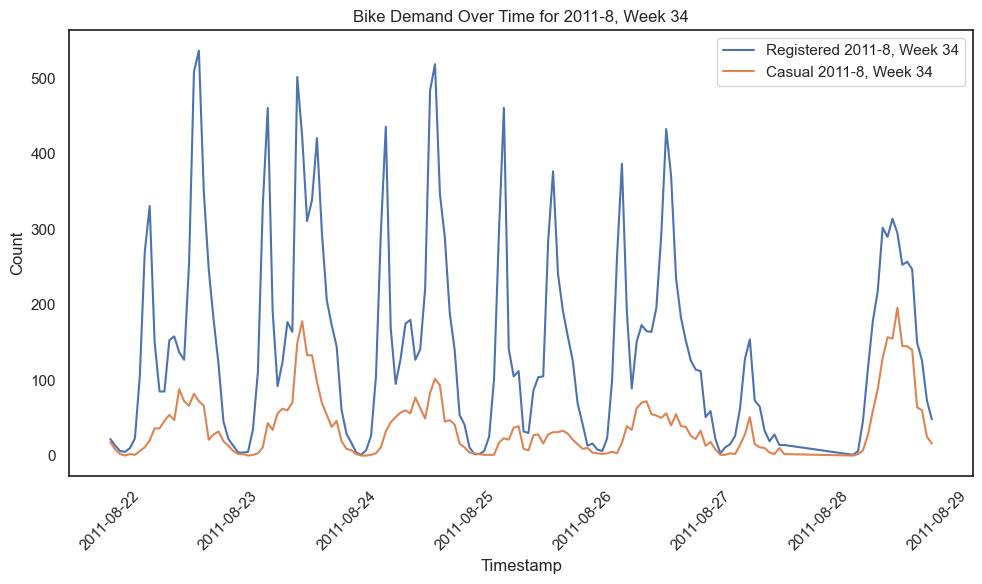

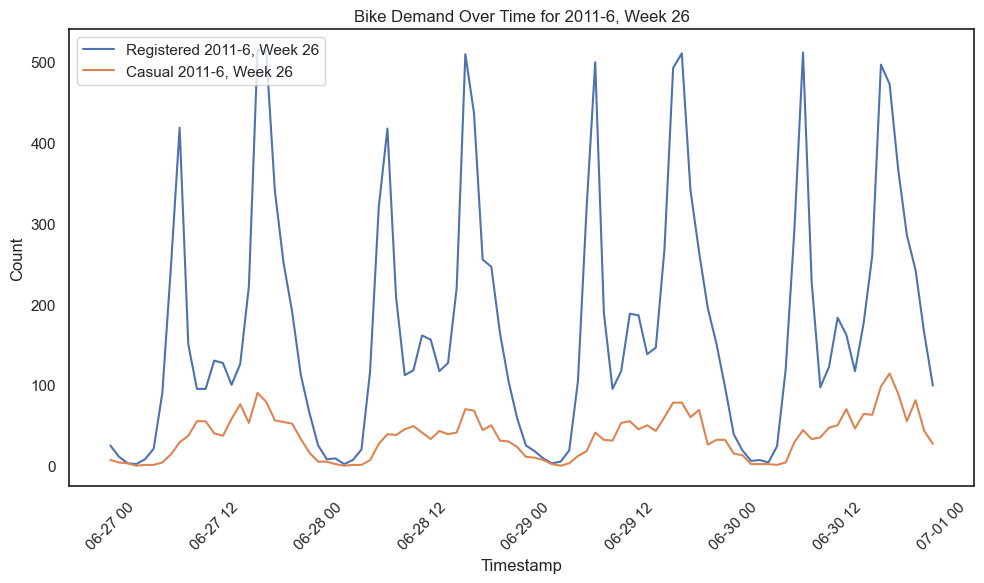

In [112]:
for _ in range(4):
    # Get unique years and months
    years = hour_processed_df['year'].unique()
    months = hour_processed_df['month'].unique()

    # Select a random year and month
    random_year = np.random.choice(years)
    random_month = np.random.choice(months)

    # Filter the dataframe for the selected year and month
    month_year_df = hour_processed_df[(hour_processed_df['year'] == random_year) & (hour_processed_df['month'] == random_month)]
    
    # Get unique weeks within this month-year and pick a random week
    weeks = month_year_df['week'].unique()
    random_week = np.random.choice(weeks)
    
    # Further filter the dataframe for the selected week
    week_df = month_year_df[month_year_df['week'] == random_week]

    # Create the plot with separate traces for registered and casual users
    plt.figure(figsize=(10, 6))
    plt.plot(week_df['timestamp'], week_df['registered'], label=f'Registered {random_year}-{random_month}, Week {random_week}')
    plt.plot(week_df['timestamp'], week_df['casual'], label=f'Casual {random_year}-{random_month}, Week {random_week}')

    plt.title(f'Bike Demand Over Time for {random_year}-{random_month}, Week {random_week}')
    plt.xlabel('Timestamp')
    plt.ylabel('Count')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 

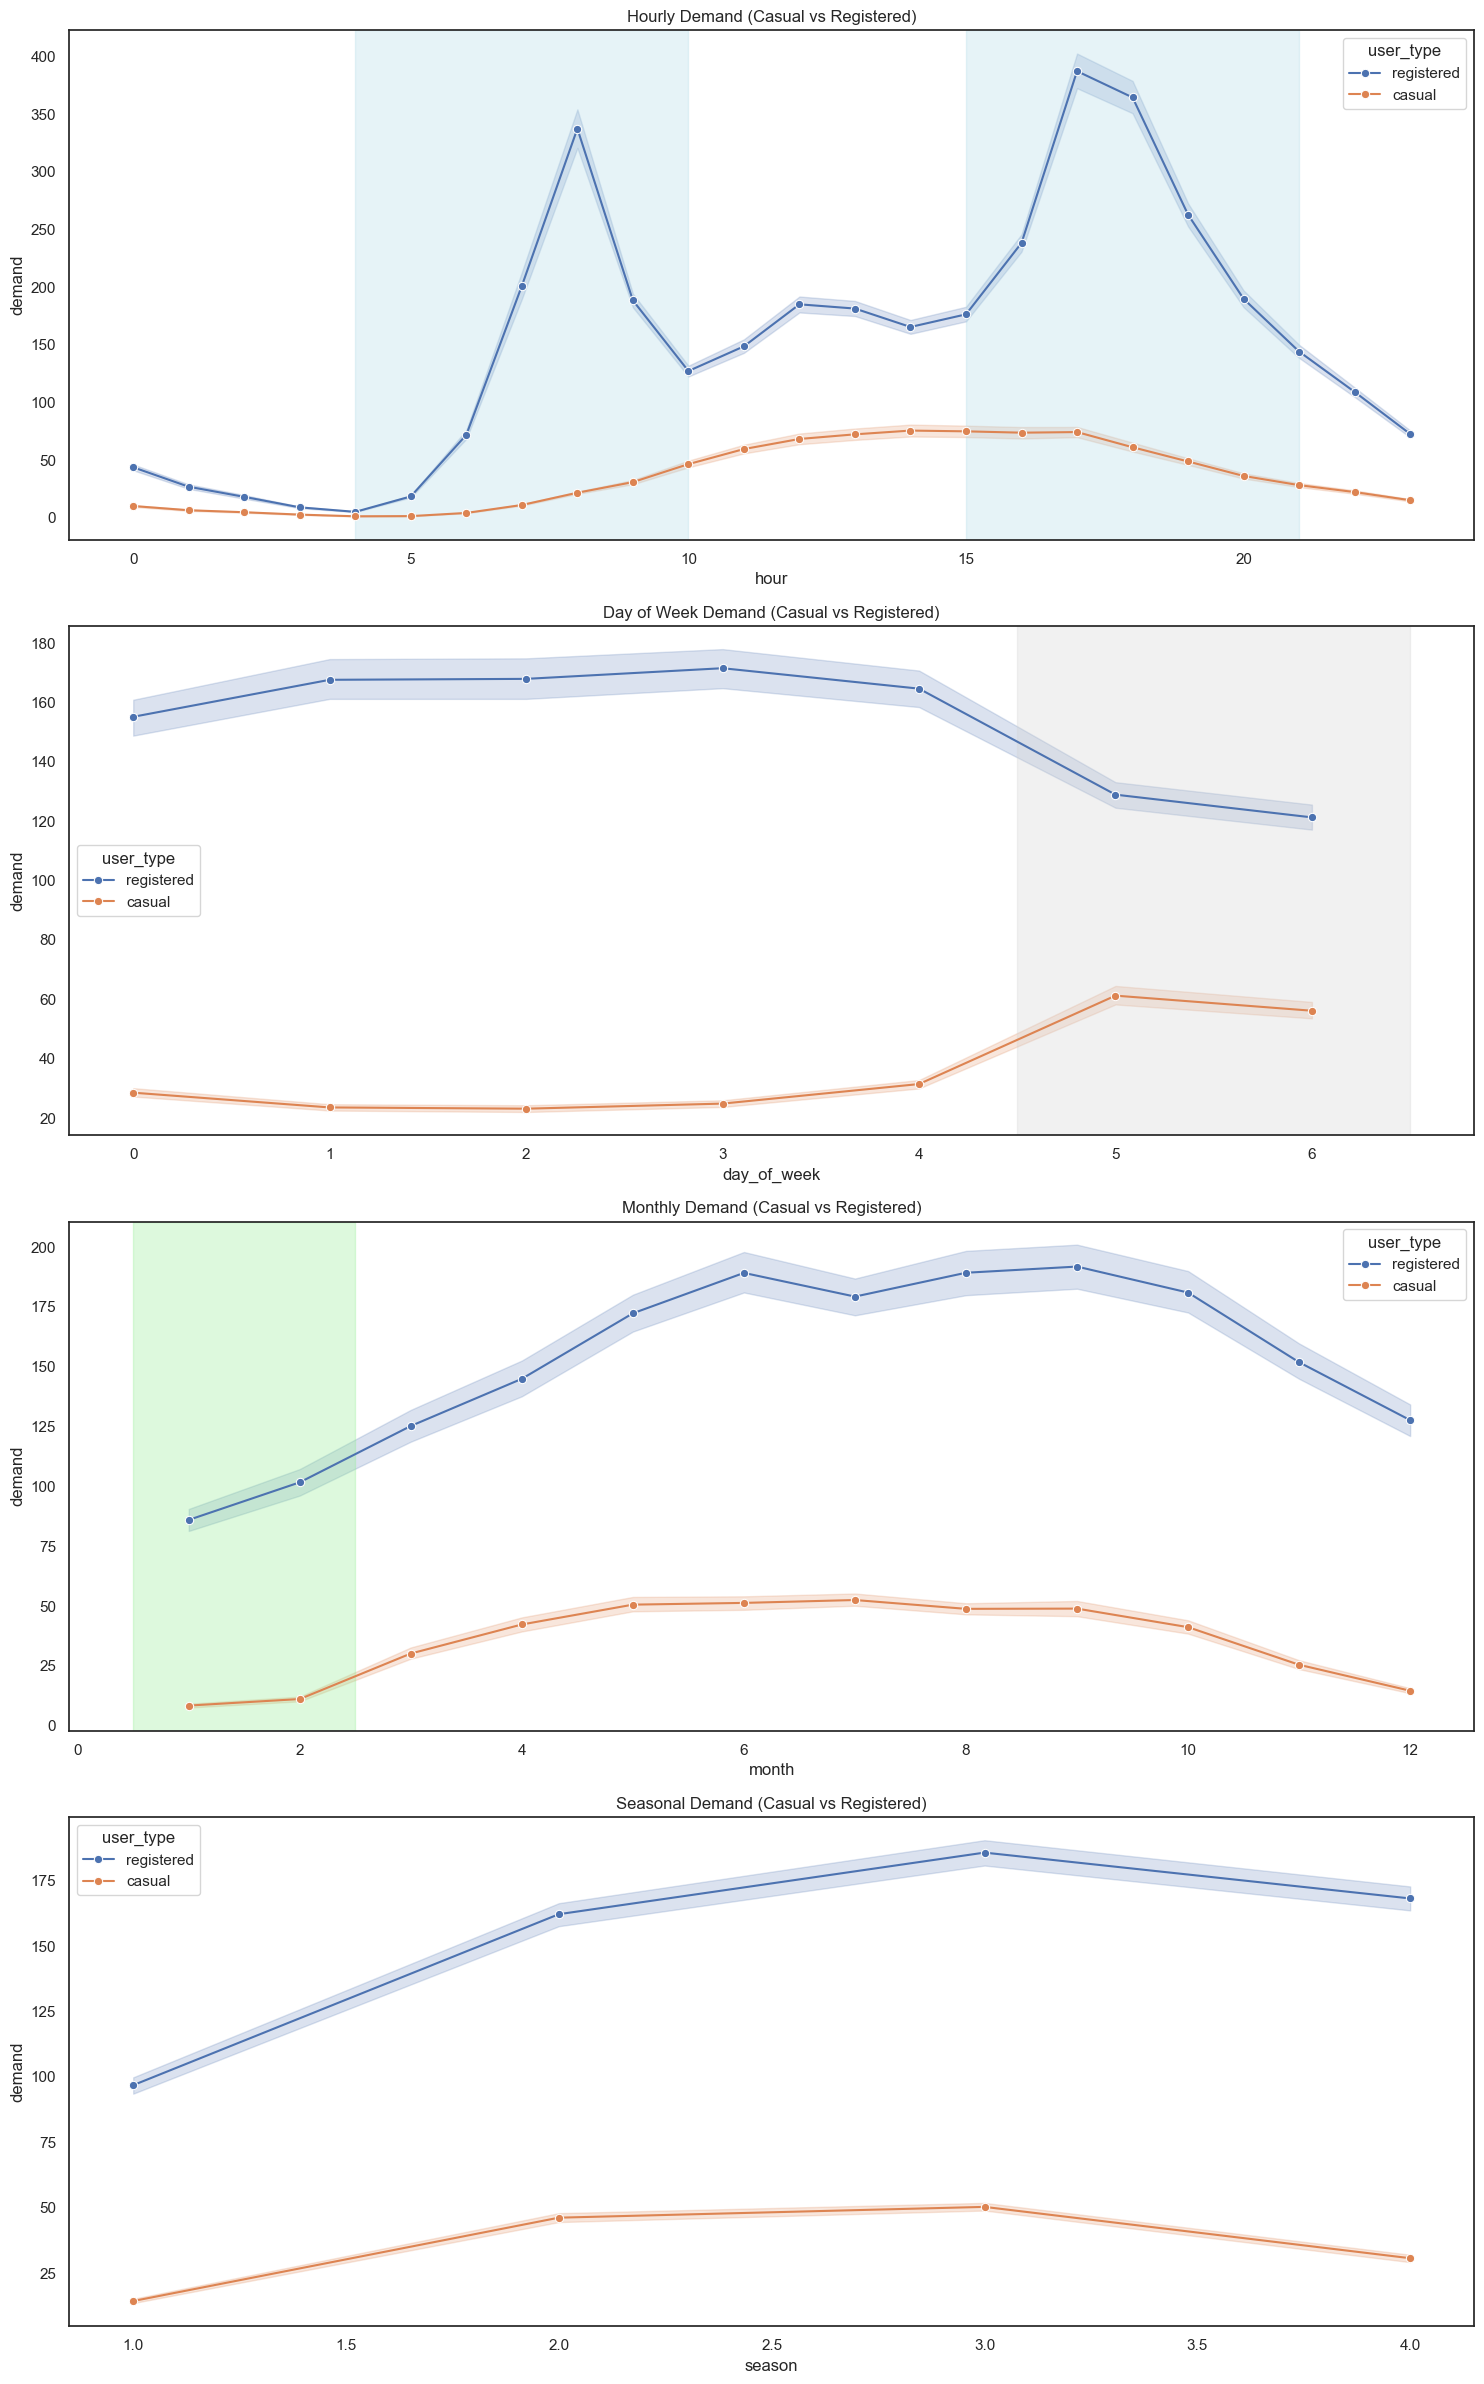

In [113]:
df_long = hour_processed_df.melt(
    id_vars=['day_of_week', 'month', 'season', 'hour', 'rush_hour'], 
    value_vars=['registered', 'casual'], 
    var_name='user_type', value_name='demand'
)

fig, axes = plt.subplots(4, 1, figsize=(15, 24))

# 1. Hourly Demand (with rush hour highlights)
sns.lineplot(x='hour', y='demand', hue='user_type', data=df_long, ax=axes[0], marker='o')
axes[0].set_title('Hourly Demand (Casual vs Registered)')
# Highlight rush hour periods (6–10 and 15–20)
axes[0].axvspan(4, 10, color='lightblue', alpha=0.3)
axes[0].axvspan(15, 21, color='lightblue', alpha=0.3)

# 2. Day of Week Demand (with weekend highlight)
sns.lineplot(x='day_of_week', y='demand', hue='user_type', data=df_long, ax=axes[1], marker='o')
axes[1].set_title('Day of Week Demand (Casual vs Registered)')
# Highlight weekend days (assumed day_of_week 5 and 6 if Monday=0)
axes[1].axvspan(4.5, 6.5, color='lightgrey', alpha=0.3)

# 3. Monthly Demand (highlighting months 1 and 2)
sns.lineplot(x='month', y='demand', hue='user_type', data=df_long, ax=axes[2], marker='o')
axes[2].set_title('Monthly Demand (Casual vs Registered)')
# Highlight months 1 and 2 (adjust the range from 0.5 to 2.5)
axes[2].axvspan(0.5, 2.5, color='lightgreen', alpha=0.3)

# 4. Seasonal Demand
sns.lineplot(x='season', y='demand', hue='user_type', data=df_long, ax=axes[3], marker='o')
axes[3].set_title('Seasonal Demand (Casual vs Registered)')

plt.tight_layout()
plt.show()


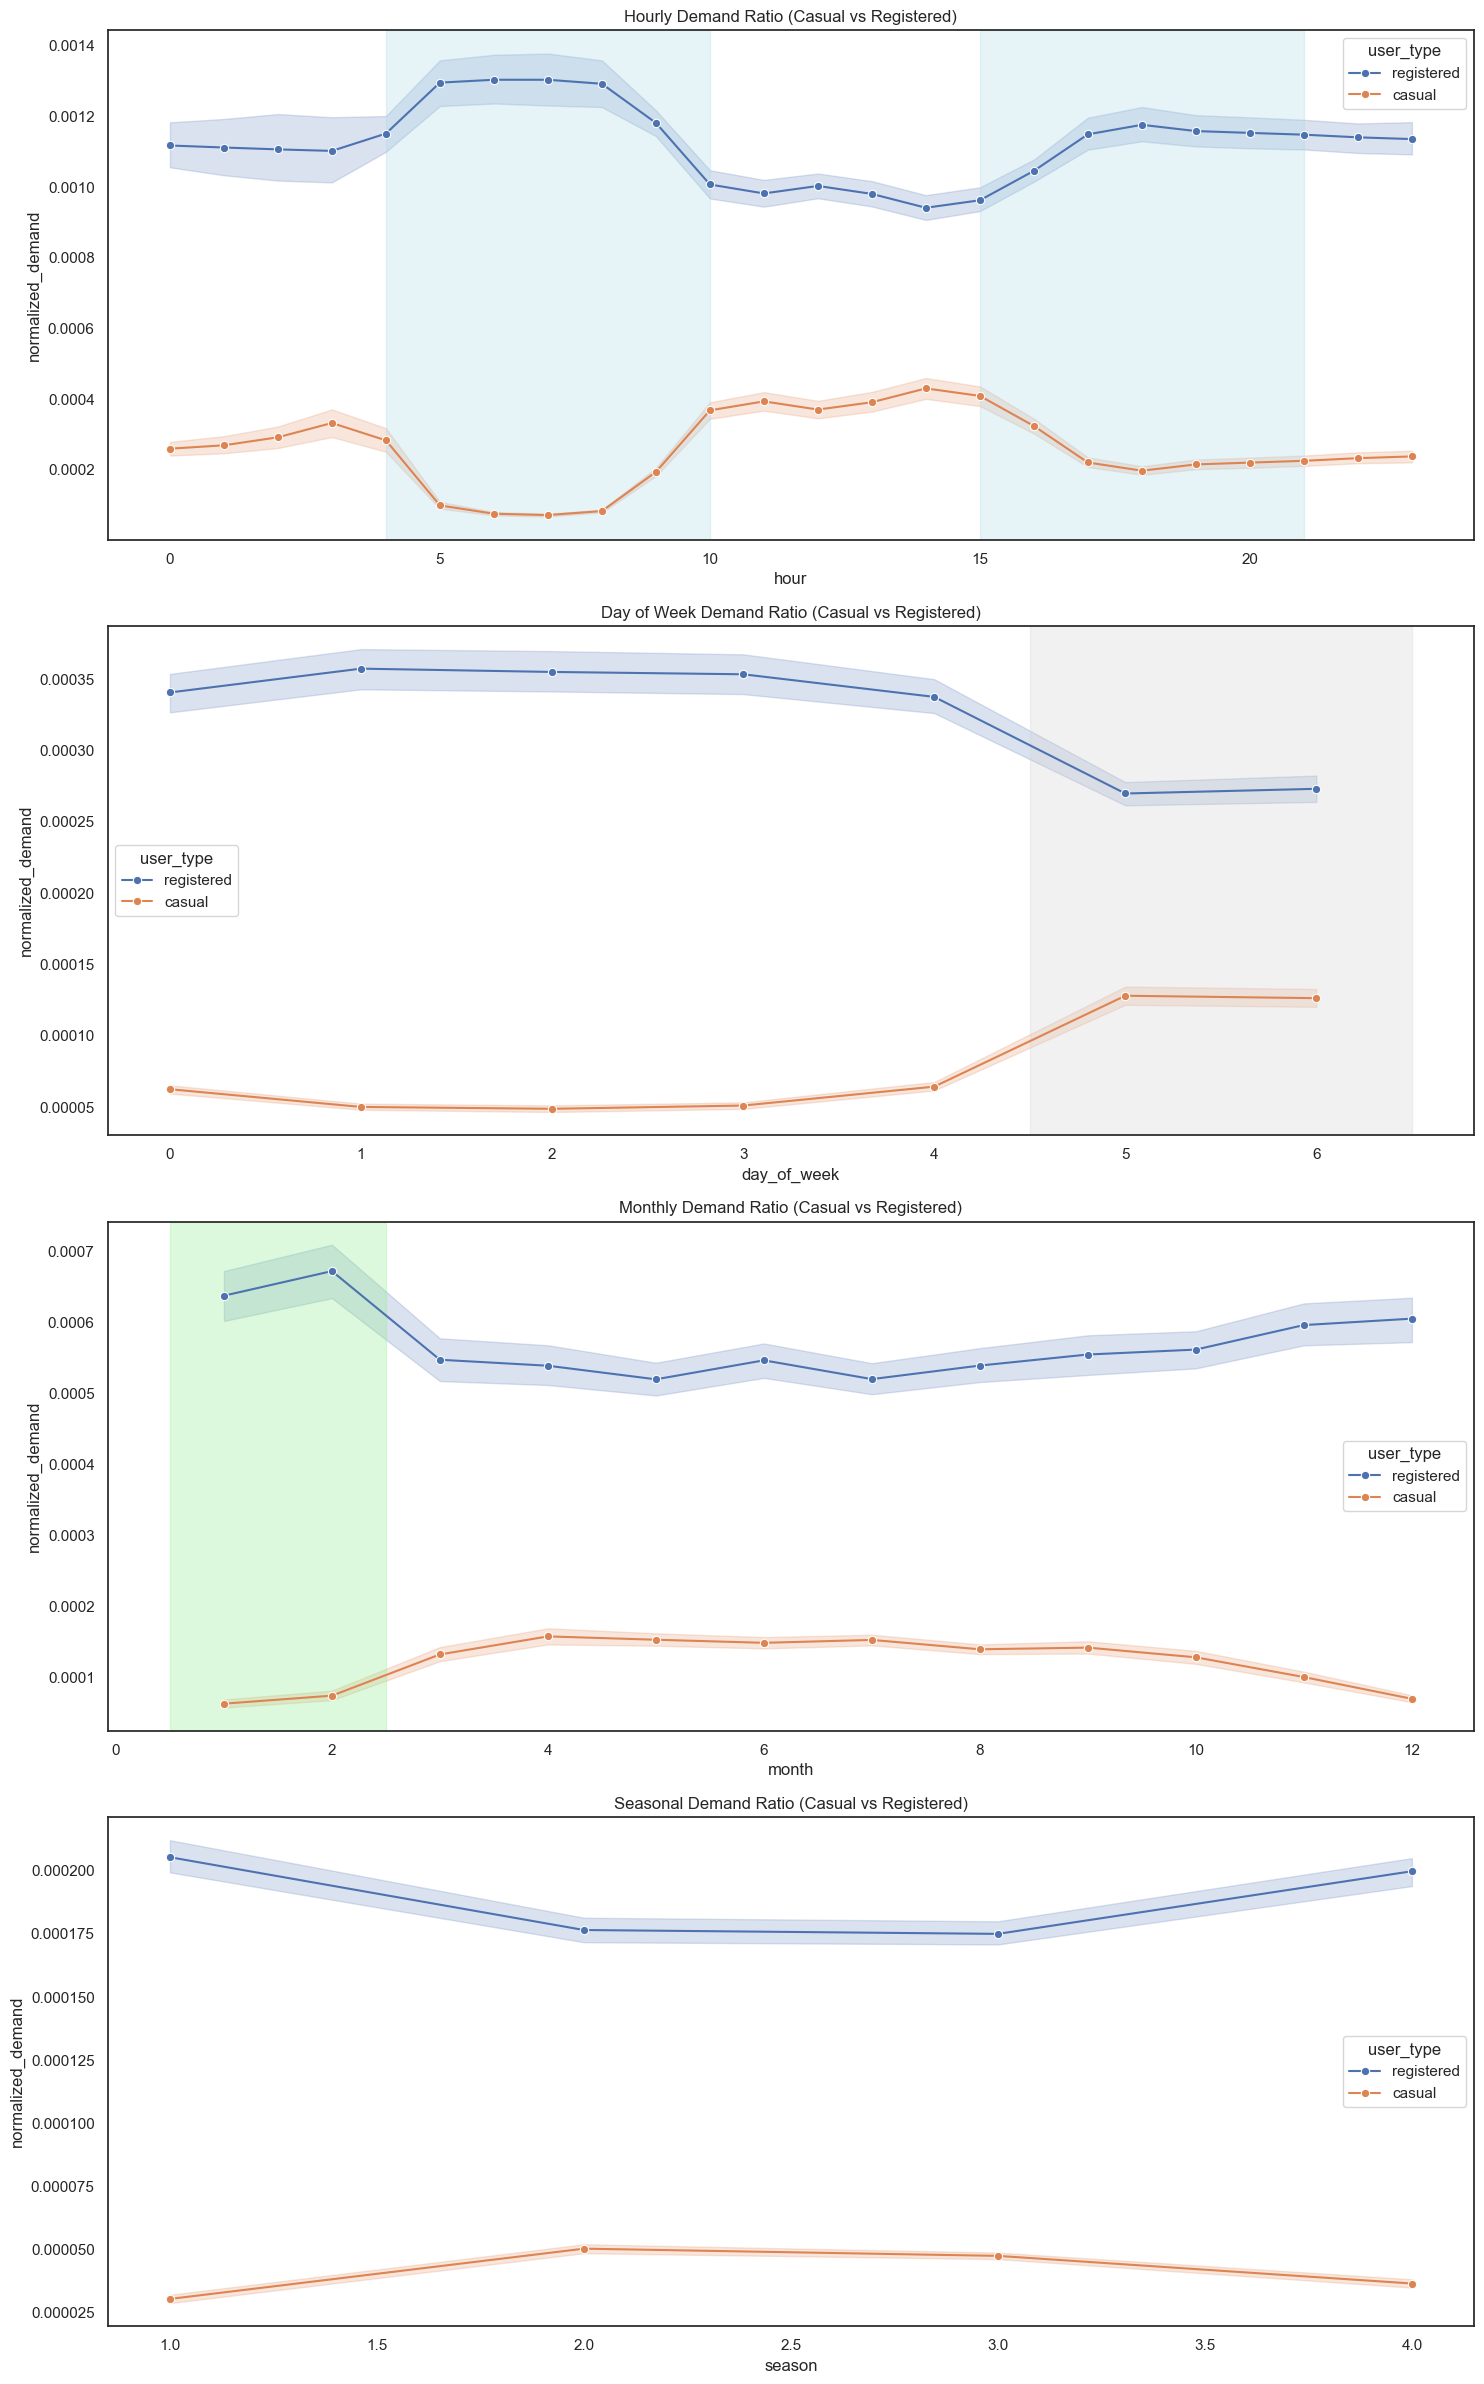

In [114]:
df_long = hour_processed_df.melt(
    id_vars=['day_of_week', 'month', 'season', 'hour', 'rush_hour'], 
    value_vars=['registered', 'casual'], 
    var_name='user_type', value_name='demand'
)

fig, axes = plt.subplots(4, 1, figsize=(15, 24))

# 1. Hourly Demand Ratio (with rush hour highlights)
df_hour = df_long.copy()
df_hour['normalized_demand'] = df_hour.groupby('hour')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='hour', y='normalized_demand', hue='user_type', data=df_hour, ax=axes[0], marker='o')
axes[0].set_title('Hourly Demand Ratio (Casual vs Registered)')
# Highlight rush hour periods (6–10 and 15–20)
axes[0].axvspan(4, 10, color='lightblue', alpha=0.3)
axes[0].axvspan(15, 21, color='lightblue', alpha=0.3)

# 2. Day of Week Demand Ratio (with weekend highlight)
df_day = df_long.copy()
df_day['normalized_demand'] = df_day.groupby('day_of_week')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='day_of_week', y='normalized_demand', hue='user_type', data=df_day, ax=axes[1], marker='o')
axes[1].set_title('Day of Week Demand Ratio (Casual vs Registered)')
# Highlight weekend days (assumed day_of_week 5 and 6 if Monday=0)
axes[1].axvspan(4.5, 6.5, color='lightgrey', alpha=0.3)

# 3. Monthly Demand Ratio (highlighting months 1 and 2)
df_month = df_long.copy()
df_month['normalized_demand'] = df_month.groupby('month')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='month', y='normalized_demand', hue='user_type', data=df_month, ax=axes[2], marker='o')
axes[2].set_title('Monthly Demand Ratio (Casual vs Registered)')
# Highlight months 1 and 2 (adjust the range from 0.5 to 2.5)
axes[2].axvspan(0.5, 2.5, color='lightgreen', alpha=0.3)

# 4. Seasonal Demand Ratio
df_season = df_long.copy()
df_season['normalized_demand'] = df_season.groupby('season')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='season', y='normalized_demand', hue='user_type', data=df_season, ax=axes[3], marker='o')
axes[3].set_title('Seasonal Demand Ratio (Casual vs Registered)')

plt.tight_layout()
plt.show()


In [115]:
train_df.columns

Index(['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'count', 'day',
       'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'week_sin', 'week_cos', 'working_day', 'weekend', 'is_monday',
       'is_friday', 'moonphase', 'quarter', 'christmas_holiday_season',
       'summer_season', 'spring_season', 'fall_season', 'winter_season',
       'day_of_year', 'is_business_hours', 'is_night', 'rush_hour',
       'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared',
       'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed',
       'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp',
       'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio',
       'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio',
       'month_ratio', 'season_ratio', 'sigma_3_o

## Distribution of the Count

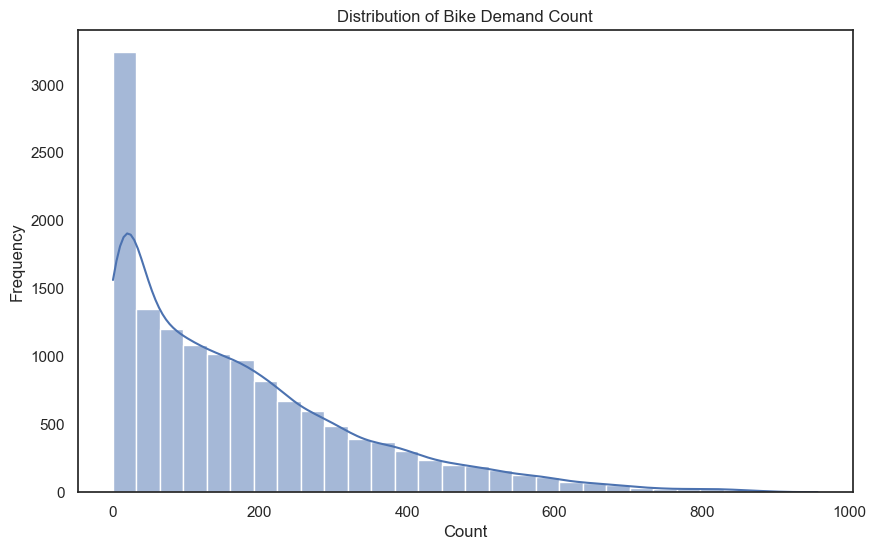

In [116]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['count'], bins=30, kde=True)
plt.title('Distribution of Bike Demand Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

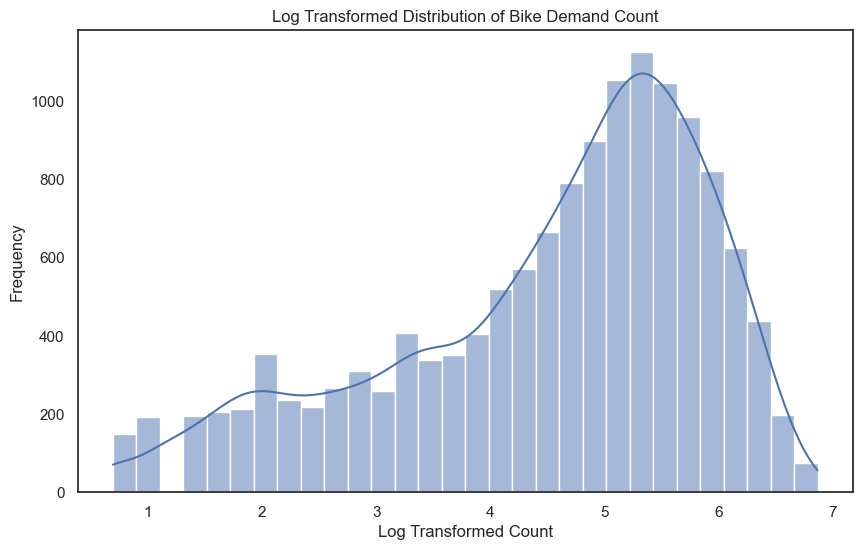

In [117]:
count_log = np.log1p(train_df['count'])  # Use log1p to handle zero values

plt.figure(figsize=(10, 6))
sns.histplot(count_log, bins=30, kde=True)
plt.title('Log Transformed Distribution of Bike Demand Count')
plt.xlabel('Log Transformed Count')
plt.ylabel('Frequency')
plt.show()

### Why Box-Cox Transformation Over Log1p?

The Box-Cox transformation was chosen over the log1p transformation for the following reasons:

1. **Flexibility**: The Box-Cox transformation is more flexible as it includes a parameter (lambda) that can be optimized to best normalize the data. This allows it to handle a wider range of data distributions compared to the log1p transformation, which is fixed.

2. **Improved Normality**: The Box-Cox transformation often results in a distribution that is closer to normality compared to log1p. This is particularly important for linear models and other statistical methods that assume normally distributed errors.

3. **Variance Stabilization**: Box-Cox can stabilize variance across the data, which can improve the performance of regression models by making the relationship between variables more linear and homoscedastic.

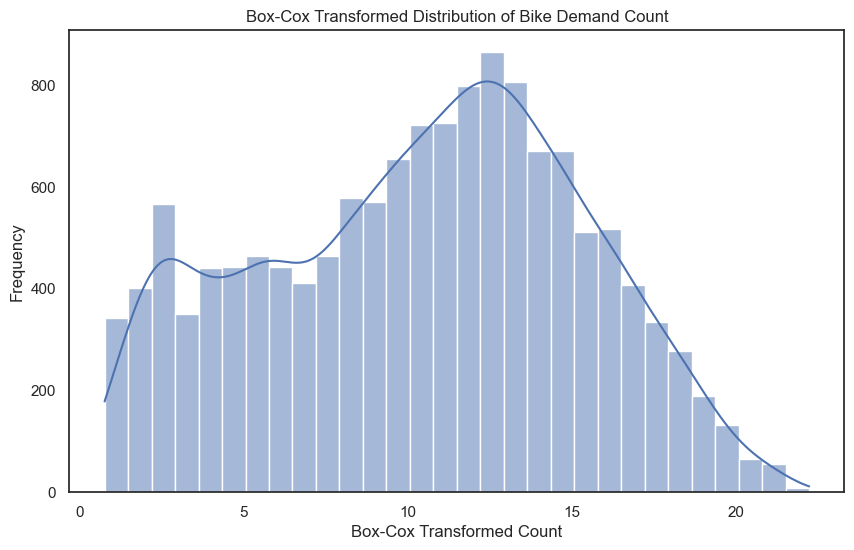

In [118]:
count_boxcox, _ = boxcox(train_df['count'] + 1)

plt.figure(figsize=(10, 6))
sns.histplot(count_boxcox, bins=30, kde=True)
plt.title('Box-Cox Transformed Distribution of Bike Demand Count')
plt.xlabel('Box-Cox Transformed Count')
plt.ylabel('Frequency')
plt.show()

## Looking at some more splits of the data by working and non-working day

2025-03-10 21:16:53,029 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-10 21:16:53,036 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-10 21:16:53,117 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-10 21:16:53,124 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-10 21:16:53,421 - INFO - Using categorical units to plot a list of strings that are all parsable as 

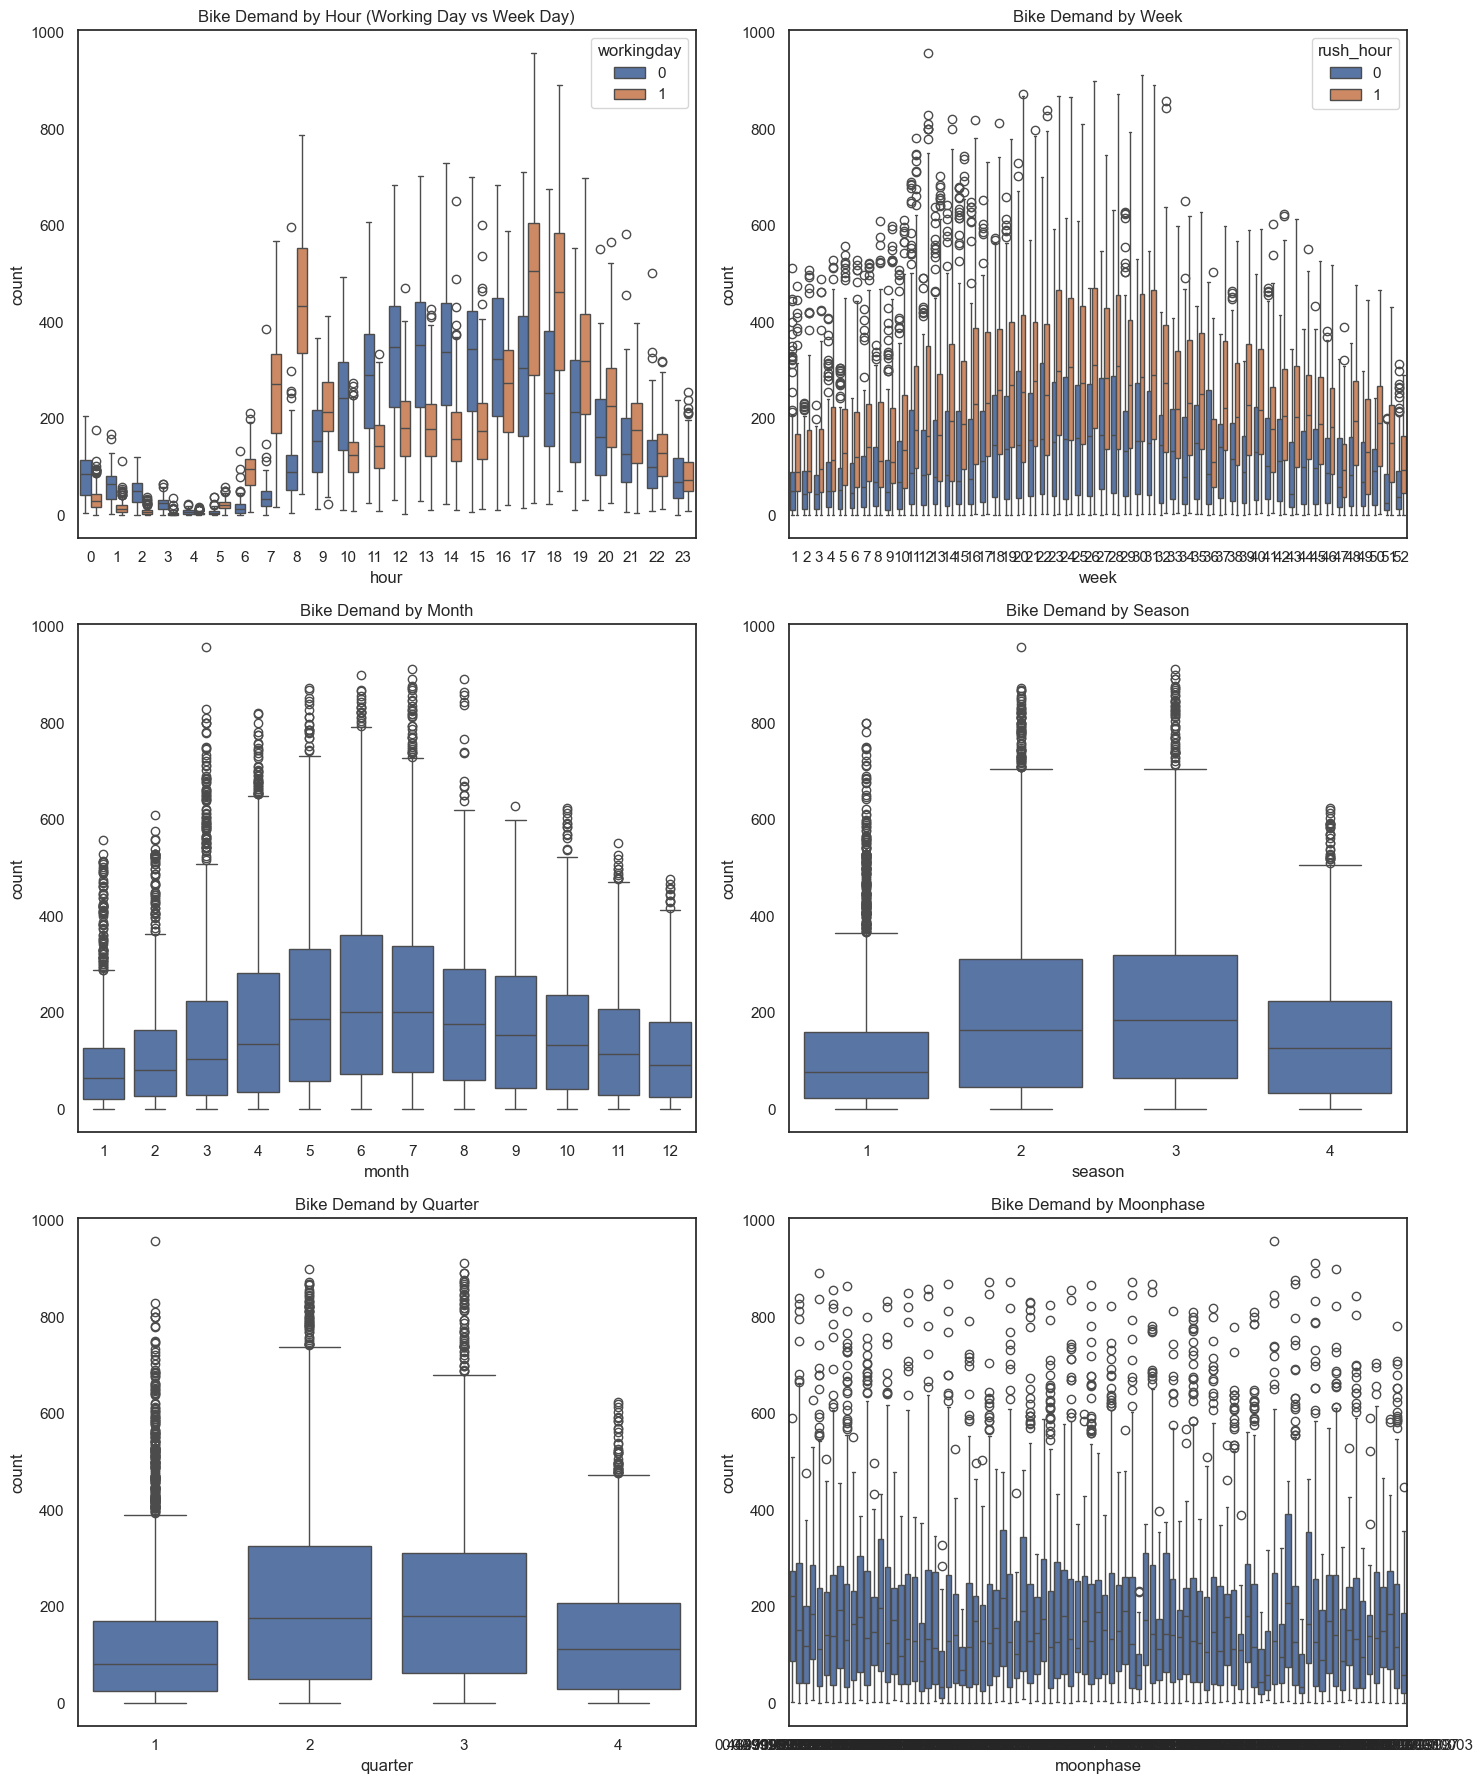

In [119]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Hour grouping
sns.boxplot(x='hour', y='count', hue='workingday', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Bike Demand by Hour (Working Day vs Week Day)')

# Week grouping
sns.boxplot(x='week', y='count', hue='rush_hour', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Bike Demand by Week')

# Month grouping
sns.boxplot(x='month', y='count', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Bike Demand by Month')

# Season grouping
sns.boxplot(x='season', y='count', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Bike Demand by Season')

# Quarter grouping
sns.boxplot(x='quarter', y='count', data=train_df, ax=axes[2, 0])
axes[2, 0].set_title('Bike Demand by Quarter')

# Moonphase grouping
sns.boxplot(x='moonphase', y='count', data=train_df, ax=axes[2, 1])
axes[2, 1].set_title('Bike Demand by Moonphase')

plt.tight_layout()
plt.show()

2025-03-10 21:16:54,396 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-10 21:16:54,403 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


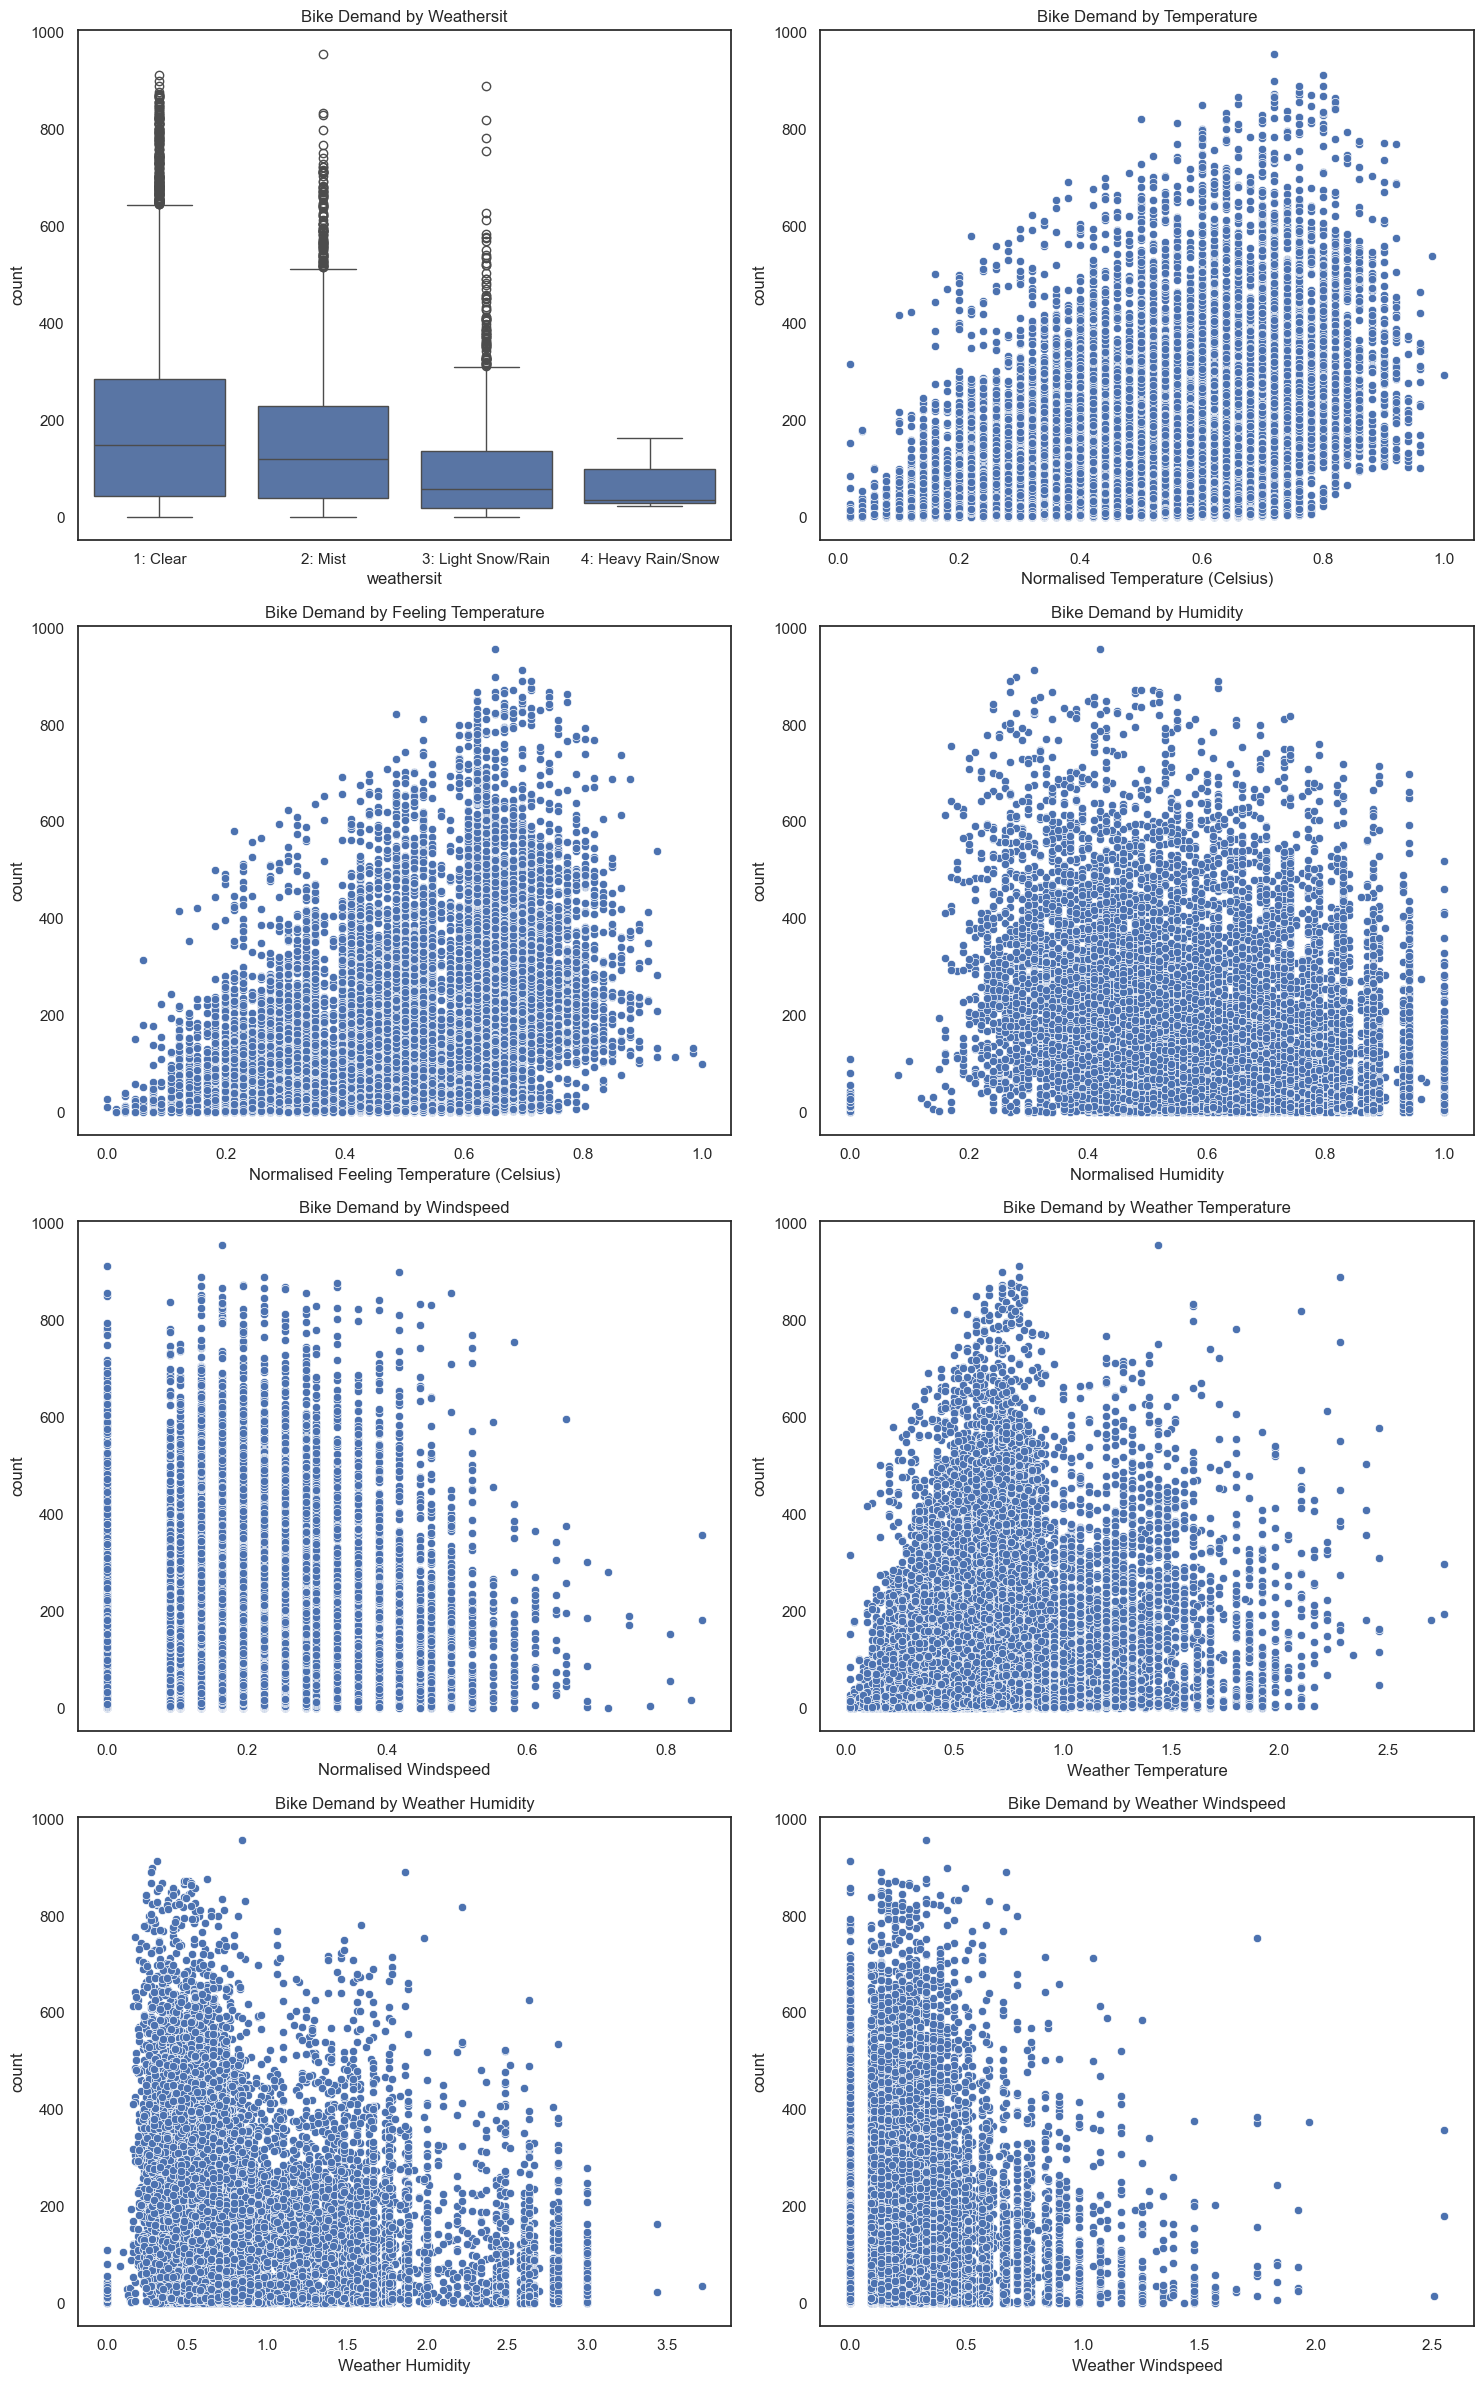

In [120]:
fig, axes = plt.subplots(4, 2, figsize=(15, 24))

sns.boxplot(x='weathersit', y='count', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Bike Demand by Weathersit')
axes[0, 0].set_xticks([0, 1, 2, 3])
axes[0, 0].set_xticklabels(['1: Clear', '2: Mist', '3: Light Snow/Rain', '4: Heavy Rain/Snow'])

sns.scatterplot(x='temp', y='count', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Bike Demand by Temperature')
axes[0, 1].set_xlabel('Normalised Temperature (Celsius)')

sns.scatterplot(x='atemp', y='count', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Bike Demand by Feeling Temperature')
axes[1, 0].set_xlabel('Normalised Feeling Temperature (Celsius)')

sns.scatterplot(x='hum', y='count', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Bike Demand by Humidity')
axes[1, 1].set_xlabel('Normalised Humidity')

sns.scatterplot(x='windspeed', y='count', data=train_df, ax=axes[2, 0])
axes[2, 0].set_title('Bike Demand by Windspeed')
axes[2, 0].set_xlabel('Normalised Windspeed')

sns.scatterplot(x='weather_temp', y='count', data=train_df, ax=axes[2, 1])
axes[2, 1].set_title('Bike Demand by Weather Temperature')
axes[2, 1].set_xlabel('Weather Temperature')

sns.scatterplot(x='weather_hum', y='count', data=train_df, ax=axes[3, 0])
axes[3, 0].set_title('Bike Demand by Weather Humidity')
axes[3, 0].set_xlabel('Weather Humidity')

sns.scatterplot(x='weather_windspeed', y='count', data=train_df, ax=axes[3, 1])
axes[3, 1].set_title('Bike Demand by Weather Windspeed')
axes[3, 1].set_xlabel('Weather Windspeed')

plt.tight_layout()
plt.show()

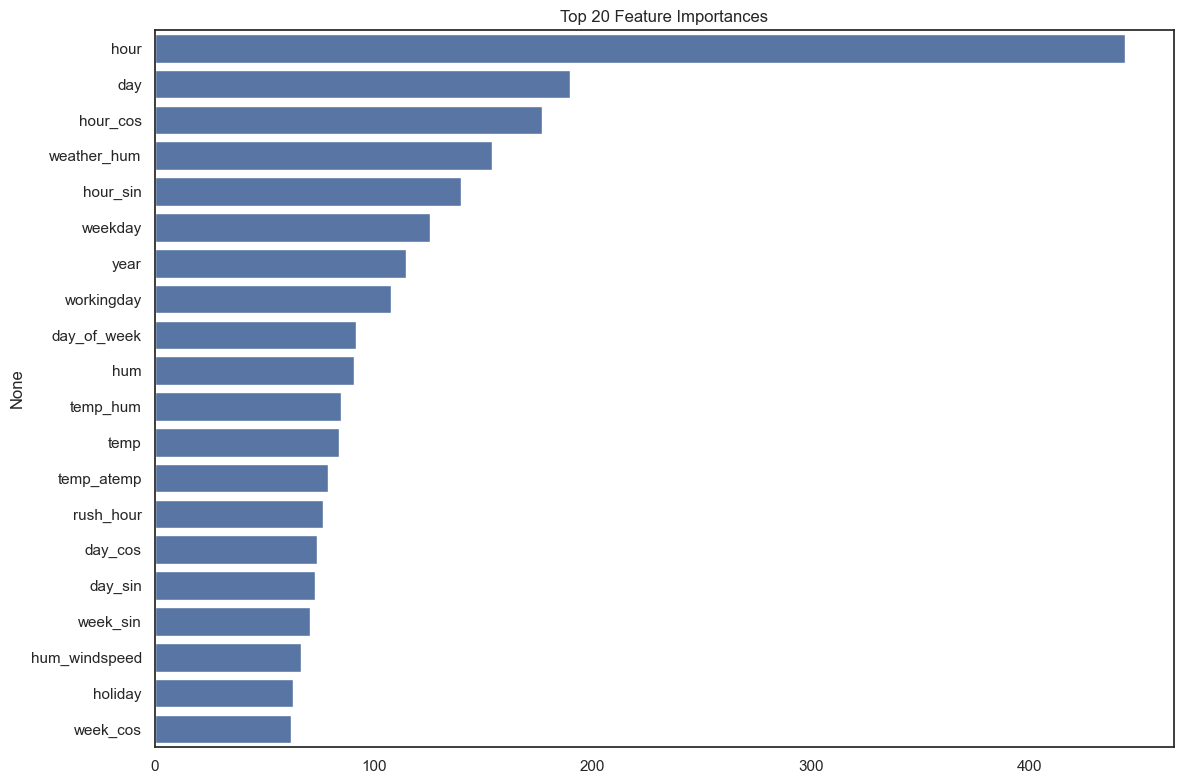

In [129]:
train_df_cleaned = train_df.copy()

for col in train_df_cleaned.select_dtypes(include=['object']).columns:
    if col != 'count':  # Don't convert the target variable if it's object type
        train_df_cleaned[col] = train_df_cleaned[col].astype('int')

model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)

X_train = train_df_cleaned.drop(columns=['count'])

y_train, lambda_value = boxcox(train_df_cleaned['count'] + 1)  # Add 1 to handle zero values
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

Root Mean Squared Error: 67.48
R^2 Score: 0.9066


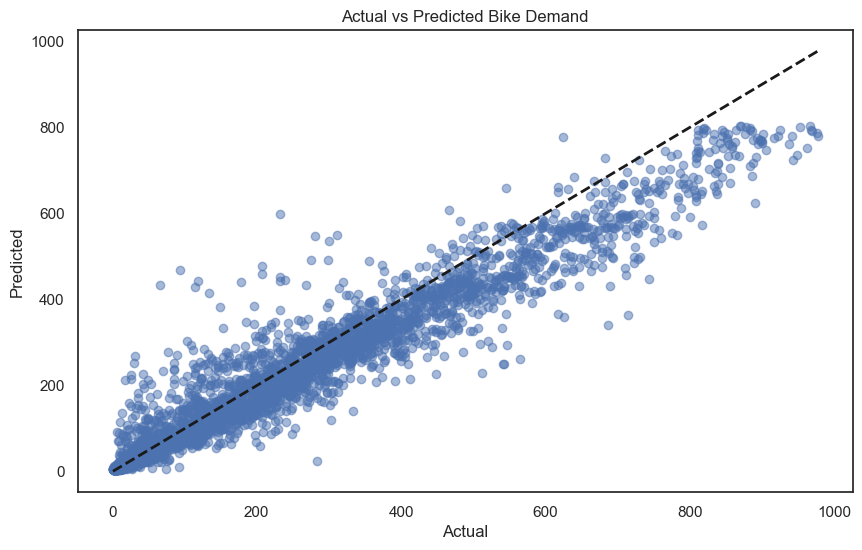

In [130]:
X_val = val_df.drop(columns=['count'])

for col in X_val.select_dtypes(include=['object']).columns:
    if col in X_train.columns:
        X_val[col] = X_val[col].astype('int')

def inverse_boxcox(y_transformed, lambda_value):
    if lambda_value == 0:
        return np.exp(y_transformed) - 1
    else:
        return (y_transformed * lambda_value + 1) ** (1 / lambda_value) - 1

y_val = val_df['count']
y_pred = inverse_boxcox(model.predict(X_val), lambda_value)

rmse = mean_squared_error(y_val, y_pred) ** 0.5
r2 = r2_score(y_val, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Bike Demand')
plt.show()

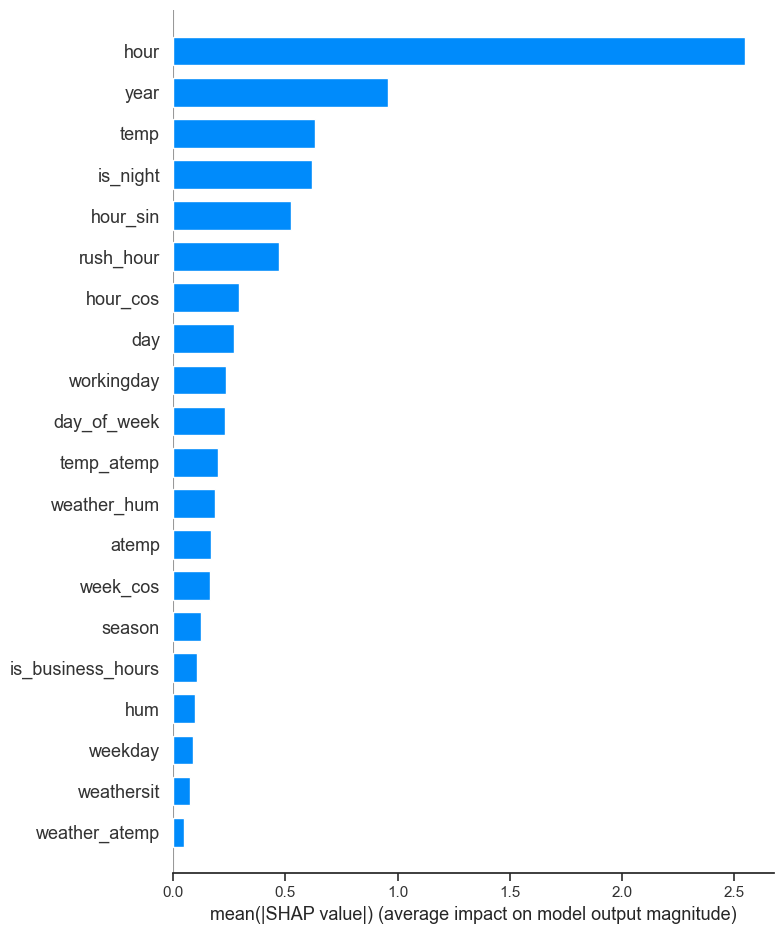

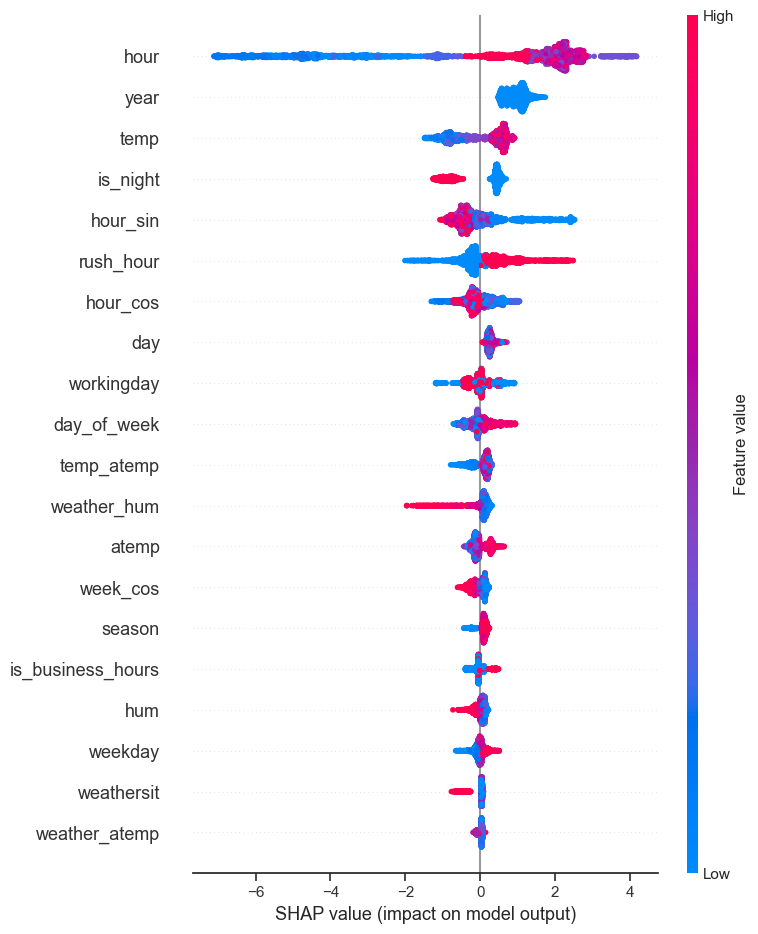

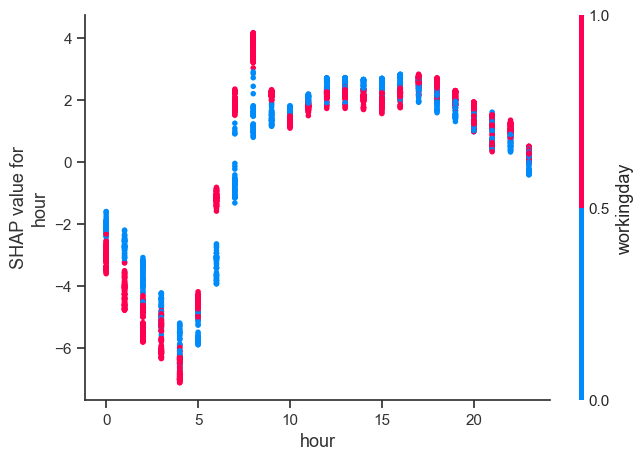

In [131]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

shap.summary_plot(shap_values, X_val)

shap.dependence_plot("hour", shap_values, X_val)

shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0, :], X_val.iloc[0, :])

Feature ranking for 1 features:
Features used for 1 features: ['temp_hum']
Number of features: 1, RMSE: 241.55, R^2: -0.1967


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 2 features:
Features used for 2 features: ['day', 'temp_hum']
Number of features: 2, RMSE: 241.97, R^2: -0.2009


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 3 features:
Features used for 3 features: ['hour', 'day', 'temp_hum']
Number of features: 3, RMSE: 171.17, R^2: 0.3991


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 4 features:
Features used for 4 features: ['hour', 'weekday', 'day', 'temp_hum']
Number of features: 4, RMSE: 149.00, R^2: 0.5447


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 5 features:
Features used for 5 features: ['hour', 'weekday', 'day', 'temp_hum', 'temp_atemp']
Number of features: 5, RMSE: 136.63, R^2: 0.6171


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 6 features:
Features used for 6 features: ['hour', 'weekday', 'day', 'temp_hum', 'weather_hum', 'temp_atemp']
Number of features: 6, RMSE: 135.58, R^2: 0.6230


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 7 features:
Features used for 7 features: ['hour', 'weekday', 'day', 'day_cos', 'temp_hum', 'weather_hum', 'temp_atemp']
Number of features: 7, RMSE: 135.71, R^2: 0.6223


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 8 features:
Features used for 8 features: ['hour', 'weekday', 'workingday', 'day', 'day_cos', 'temp_hum', 'weather_hum', 'temp_atemp']
Number of features: 8, RMSE: 132.68, R^2: 0.6390


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 9 features:
Features used for 9 features: ['hour', 'weekday', 'workingday', 'day', 'day_cos', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp']
Number of features: 9, RMSE: 132.94, R^2: 0.6376


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 10 features:
Features used for 10 features: ['hour', 'weekday', 'workingday', 'day', 'day_cos', 'hour_cos', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp']
Number of features: 10, RMSE: 131.40, R^2: 0.6459


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 11 features:
Features used for 11 features: ['hour', 'weekday', 'workingday', 'day', 'day_of_week', 'day_cos', 'hour_cos', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp']
Number of features: 11, RMSE: 132.00, R^2: 0.6426


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 12 features:
Features used for 12 features: ['hour', 'weekday', 'workingday', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp']
Number of features: 12, RMSE: 131.21, R^2: 0.6469


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 13 features:
Features used for 13 features: ['year', 'hour', 'weekday', 'workingday', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp']
Number of features: 13, RMSE: 66.52, R^2: 0.9092


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 14 features:
Features used for 14 features: ['year', 'hour', 'weekday', 'workingday', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp']
Number of features: 14, RMSE: 66.01, R^2: 0.9106


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 15 features:
Features used for 15 features: ['year', 'hour', 'weekday', 'workingday', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp']
Number of features: 15, RMSE: 65.82, R^2: 0.9111


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 16 features:
Features used for 16 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp']
Number of features: 16, RMSE: 66.33, R^2: 0.9098


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 17 features:
Features used for 17 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'hum', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp']
Number of features: 17, RMSE: 65.58, R^2: 0.9118


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 18 features:
Features used for 18 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'hum', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'moonphase', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp']
Number of features: 18, RMSE: 64.49, R^2: 0.9147


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 19 features:
Features used for 19 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'hum', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp']
Number of features: 19, RMSE: 64.07, R^2: 0.9158


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 20 features:
Features used for 20 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp']
Number of features: 20, RMSE: 63.87, R^2: 0.9163


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 21 features:
Features used for 21 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'weather_hum', 'weather_windspeed', 'temp_atemp', 'weather_atemp']
Number of features: 21, RMSE: 64.40, R^2: 0.9149


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 22 features:
Features used for 22 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'weather_hum', 'weather_windspeed', 'temp_atemp', 'weather_atemp']
Number of features: 22, RMSE: 66.47, R^2: 0.9094


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 23 features:
Features used for 23 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'weather_hum', 'weather_windspeed', 'temp_atemp', 'weather_atemp']
Number of features: 23, RMSE: 67.90, R^2: 0.9054


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 24 features:
Features used for 24 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'weather_temp', 'weather_hum', 'weather_windspeed', 'temp_atemp', 'weather_atemp']
Number of features: 24, RMSE: 69.11, R^2: 0.9021


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 25 features:
Features used for 25 features: ['year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'weather_temp', 'weather_hum', 'weather_windspeed', 'temp_atemp', 'weather_atemp']
Number of features: 25, RMSE: 67.71, R^2: 0.9060


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 26 features:
Features used for 26 features: ['year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'temp_atemp', 'weather_atemp']
Number of features: 26, RMSE: 67.98, R^2: 0.9052


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 27 features:
Features used for 27 features: ['year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'temp_atemp', 'weather_atemp']
Number of features: 27, RMSE: 67.92, R^2: 0.9054


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 28 features:
Features used for 28 features: ['year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 28, RMSE: 68.74, R^2: 0.9031


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 29 features:
Features used for 29 features: ['year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_of_month', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 29, RMSE: 69.02, R^2: 0.9023


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 30 features:
Features used for 30 features: ['year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_of_month', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 30, RMSE: 66.28, R^2: 0.9099


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 31 features:
Features used for 31 features: ['season', 'year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_of_month', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 31, RMSE: 67.09, R^2: 0.9077


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 32 features:
Features used for 32 features: ['season', 'year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_of_month', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 32, RMSE: 67.53, R^2: 0.9065


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 33 features:
Features used for 33 features: ['season', 'year', 'hour', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_of_month', 'week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 33, RMSE: 68.05, R^2: 0.9050


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 34 features:
Features used for 34 features: ['season', 'year', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_of_month', 'week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 34, RMSE: 66.82, R^2: 0.9084


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 35 features:
Features used for 35 features: ['season', 'year', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'day', 'day_of_week', 'day_of_month', 'week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 35, RMSE: 67.22, R^2: 0.9073


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 36 features:
Features used for 36 features: ['season', 'year', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 36, RMSE: 67.04, R^2: 0.9078


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 37 features:
Features used for 37 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff']
Number of features: 37, RMSE: 67.04, R^2: 0.9078


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 38 features:
Features used for 38 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'sigma_3_outlier']
Number of features: 38, RMSE: 67.32, R^2: 0.9070


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 39 features:
Features used for 39 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'sigma_3_outlier']
Number of features: 39, RMSE: 66.72, R^2: 0.9087


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 40 features:
Features used for 40 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'sigma_3_outlier']
Number of features: 40, RMSE: 65.60, R^2: 0.9117


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 41 features:
Features used for 41 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'summer_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'sigma_3_outlier']
Number of features: 41, RMSE: 66.62, R^2: 0.9090


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 42 features:
Features used for 42 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'moonphase', 'summer_season', 'spring_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'sigma_3_outlier']
Number of features: 42, RMSE: 66.37, R^2: 0.9097


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 43 features:
Features used for 43 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'summer_season', 'spring_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'sigma_3_outlier']
Number of features: 43, RMSE: 65.80, R^2: 0.9112


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 44 features:
Features used for 44 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'sigma_3_outlier']
Number of features: 44, RMSE: 67.02, R^2: 0.9079


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 45 features:
Features used for 45 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'sigma_3_outlier']
Number of features: 45, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 46 features:
Features used for 46 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'month_ratio', 'sigma_3_outlier']
Number of features: 46, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 47 features:
Features used for 47 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'month_ratio', 'sigma_3_outlier']
Number of features: 47, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 48 features:
Features used for 48 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'month_ratio', 'sigma_3_outlier']
Number of features: 48, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 49 features:
Features used for 49 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 49, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 50 features:
Features used for 50 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 50, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 51 features:
Features used for 51 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 51, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 52 features:
Features used for 52 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 52, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 53 features:
Features used for 53 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 53, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 54 features:
Features used for 54 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 54, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 55 features:
Features used for 55 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 55, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 56 features:
Features used for 56 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_monday', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 56, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 57 features:
Features used for 57 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'is_monday', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 57, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 58 features:
Features used for 58 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'weekend', 'is_monday', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 58, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 59 features:
Features used for 59 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'working_day', 'weekend', 'is_monday', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 59, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 60 features:
Features used for 60 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'working_day', 'weekend', 'is_monday', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'fall_season', 'winter_season', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 60, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 61 features:
Features used for 61 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'working_day', 'weekend', 'is_monday', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'fall_season', 'winter_season', 'day_of_year', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'sigma_3_outlier']
Number of features: 61, RMSE: 67.48, R^2: 0.9066


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 62 features:
Features used for 62 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'working_day', 'weekend', 'is_monday', 'is_friday', 'moonphase', 'christmas_holiday_season', 'summer_season', 'spring_season', 'fall_season', 'winter_season', 'day_of_year', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'sigma_3_outlier']
Number of features: 62, RMSE: 67.48, R^2: 0.

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Feature ranking for 63 features:
Features used for 63 features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'working_day', 'weekend', 'is_monday', 'is_friday', 'moonphase', 'quarter', 'christmas_holiday_season', 'summer_season', 'spring_season', 'fall_season', 'winter_season', 'day_of_year', 'is_business_hours', 'is_night', 'rush_hour', 'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'sigma_3_outlier']
Number of features: 63, RMSE: 67.

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



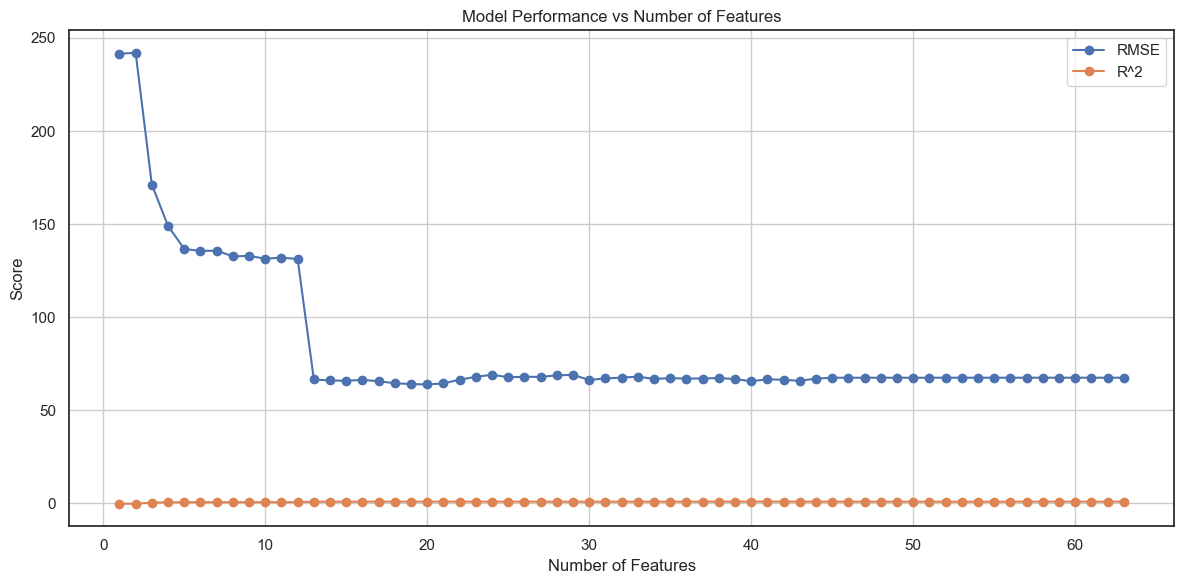

In [132]:
X_train = train_df.drop(columns=['count'])
y_train, lambda_value = boxcox(train_df['count'] + 1) 

X_val = val_df.drop(columns=['count'])
y_val = val_df['count']

scores = []

for n_features in range(1, X_train.shape[1] + 1):
    rfe = RFE(estimator=model, n_features_to_select=n_features, step=1, importance_getter="feature_importances_")

    rfe = rfe.fit(X_train, y_train)
    
    ranking = rfe.ranking_
    features = X_train.columns
    
    feature_ranking = sorted(zip(ranking, features))
    print(f"Feature ranking for {n_features} features:")
    
    selected_features = X_train.columns[rfe.support_]
    print(f"Features used for {n_features} features: {selected_features.tolist()}")
    
    y_pred = inverse_boxcox(rfe.predict(X_val), lambda_value)
    
    rmse = mean_squared_error(y_val, y_pred) ** 0.5
    r2 = r2_score(y_val, y_pred)
    
    scores.append((n_features, rmse, r2))
    print(f"Number of features: {n_features}, RMSE: {rmse:.2f}, R^2: {r2:.4f}")

scores_df = pd.DataFrame(scores, columns=['n_features', 'rmse', 'r2'])

plt.figure(figsize=(12, 6))
plt.plot(scores_df['n_features'], scores_df['rmse'], marker='o', label='RMSE')
plt.plot(scores_df['n_features'], scores_df['r2'], marker='o', label='R^2')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit


min_features_to_select = 1  # Minimum number of features to consider
clf =  LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
cv = TimeSeriesSplit(5)

datadata = hour_processed_df.iloc[-14*27:].drop(['casual', 'registered'], axis=1)
X = datadata.drop(['count'], axis=1)
y = datadata['count']

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Top 15 features: ['year', 'hour', 'weekday', 'workingday', 'temp', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hour_cos', 'hum_windspeed', 'temp_hum', 'weather_temp', 'weather_hum', 'temp_atemp']
Root Mean Squared Error: 64.31
R^2 Score: 0.9149


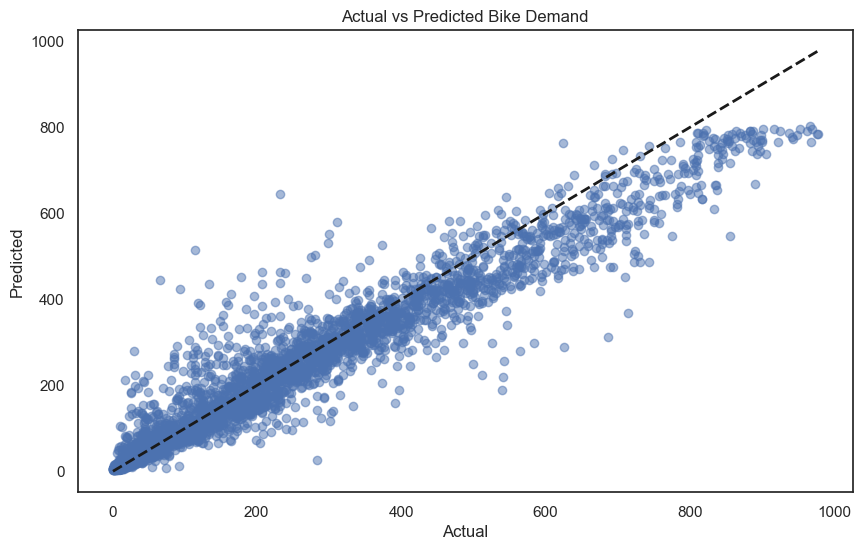

In [ ]:
model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42, verbose=-1)

X_train = train_df.drop(columns=['count'])
y_train, lambda_value = boxcox(train_df['count'] + 1)  # Apply Box-Cox transformation to the target variable

X_val = val_df.drop(columns=['count'])
y_val = val_df['count']

rfe = RFE(estimator=model, n_features_to_select=15, step=1)
rfe = rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print(f"Top 15 features: {selected_features.tolist()}")

model.fit(X_train[selected_features], y_train)

y_pred = inverse_boxcox(model.predict(X_val[selected_features]), lambda_value)

rmse = mean_squared_error(y_val, y_pred) ** 0.5
r2 = r2_score(y_val, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Bike Demand')
plt.show()